In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from matplotlib.colors import ListedColormap, BoundaryNorm

from zoneinfo import ZoneInfo
from datetime import datetime, timezone

HOME = '/user/home/uz22147/repos/downscaling-cgan/'
sys.path.insert(1, str(HOME))

In [3]:
from dsrnngan.evaluation.plots import plot_precipitation, plot_contourf, range_dict, quantile_locs, plot_quantiles
from dsrnngan.data.data import denormalise, DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
from dsrnngan.data import data
from dsrnngan.model.noise import NoiseGenerator
from dsrnngan.evaluation.rapsd import plot_spectrum1d, rapsd
from dsrnngan.evaluation.thresholded_ranks import findthresh
from dsrnngan.evaluation import scoring
from dsrnngan.utils.utils import get_best_model_number
from dsrnngan.evaluation.benchmarks import QuantileMapper

2023-09-01 11:38:50.862649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-01 11:38:50.862707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
model_type = 'final-nologs'

log_folders = {'basic': '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201806-201905_e50',
               'full_image': '/user/work/uz22147/logs/cgan/43ae7be47e9a182e_full_image/n1000_201806-201905_e50',
               'cropped': '/user/work/uz22147/logs/cgan/5c577a485fbd1a72_0876a13533d2542c/n4000_201806-201905_e10',
               'small1': '/user/work/uz22147/logs/cgan/7ed5693482c955aa_small-cl1000/n4000_201806-201905_e10',
               'small2': '/user/work/uz22147/logs/cgan/7ed5693482c955aa_small-cl2000/n4000_201806-201905_e10',
               '2step': '/user/work/uz22147/logs/cgan/7ed5693482c955aa_small-2step-ds/n4000_201806-201905_e20',
               'nologs': '/user/work/uz22147/logs/cgan/76b8618700c90131_medium-cl10-no-logs/n4000_201806-201905_e10',
               'nologs_small50': '/user/work/uz22147/logs/cgan/76b8618700c90131_cl50-no-logs/n4000_201806-201905_e10',
               'final-cl2000': {'log_folder': '/user/work/uz22147/logs/cgan/457221781d3b7cc9_medium-cl2000-final/n2900_201806-201903_42e34_e20', 'model_number': 262400},
               'final-nologs': {'log_folder': '/user/work/uz22147/logs/cgan/7c4126e641f81ae0_medium-cl100-final-nologs/n4000_202010-202109_45682_e20', 'model_number': 217600}
}


# Get best model
if isinstance(log_folders[model_type], str):
    log_folder = log_folders[model_type]

    # model_number = get_best_model_number(log_folder=log_folder)
    model_number=268800
else:
    
    model_number = log_folders[model_type]['model_number']
    log_folder = log_folders[model_type]['log_folder']

with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)
    
folder_suffix = log_folder.split('/')[-1]
plot_dir = os.path.join('/user/home/uz22147/repos/downscaling-cgan/plots', folder_suffix)

n_samples =  arrays['truth'].shape[0]
# n_samples = 500
truth_array = arrays['truth'][:n_samples, :, :]
samples_gen_array = arrays['samples_gen'][:n_samples, :,:,:]
fcst_array = arrays['fcst_array'][:n_samples, :,: ]
persisted_fcst_array = arrays['persisted_fcst'][:n_samples, :,: ]
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)[:n_samples, :,:]
dates = [d[0] for d in arrays['dates']][:n_samples]
hours = [h[0] for h in arrays['hours']][:n_samples]

eat_datetimes = [datetime(d.year, d.month, d.day, hours[n]).replace(tzinfo=timezone.utc).astimezone(ZoneInfo('Africa/Nairobi')) for n,d in enumerate(dates)]
dates = [datetime(d.year, d.month, d.day) for d in eat_datetimes]
hours = [d.hour for d in eat_datetimes]

assert len(set(list(zip(dates, hours)))) == fcst_array.shape[0], "Degenerate date/hour combinations"
(n_samples, width, height, ensemble_size) = samples_gen_array.shape


In [5]:
del arrays

In [6]:
from dsrnngan.utils.utils import load_yaml_file
from dsrnngan.utils import read_config
# Get lat/lon range from log folder
base_folder = '/'.join(log_folder.split('/')[:-1])
try:
    config = load_yaml_file(os.path.join(base_folder, 'setup_params.yaml'))
    model_config, data_config = read_config.get_config_objects(config)
except FileNotFoundError:
    data_config = read_config.read_data_config(config_folder=base_folder)
    
# Locations
latitude_range, longitude_range = read_config.get_lat_lon_range_from_config(data_config)

lat_range_list = [np.round(item, 2) for item in sorted(latitude_range)]
lon_range_list = [np.round(item, 2) for item in sorted(longitude_range)]

special_areas = {'Lake Victoria': {'lat_range': [-3.05,0.95], 'lon_range': [31.55, 34.55], 'color': 'red'},
                 'Coastal Kenya/Somalia': {'lat_range': [-4.65, 5.45], 'lon_range': [38.85, 48.3], 'color': 'black'},
                 'West EA Rift': {'lat_range': [-4.70,0.30], 'lon_range': [28.25,31.3], 'color': 'green'},
                 'East EA Rift': {'lat_range': [-3.15, 1.55], 'lon_range': [33.85,36.55], 'color': 'purple'},
                 'NW Ethiopian Highlands': {'lat_range': [6.10, 14.15], 'lon_range': [34.60, 40.30], 'color': 'blue'}}

for k, v in special_areas.items():
    lat_vals = [lt for lt in lat_range_list if v['lat_range'][0] <= lt <= v['lat_range'][1]]
    lon_vals = [ln for ln in lon_range_list if v['lon_range'][0] <= ln <= v['lon_range'][1]]
    
    if lat_vals and lon_vals:
 
        special_areas[k]['lat_index_range'] = [lat_range_list.index(lat_vals[0]), lat_range_list.index(lat_vals[-1])]
        special_areas[k]['lon_index_range'] = [lon_range_list.index(lon_vals[0]), lon_range_list.index(lon_vals[-1])]

## Summary of data

In [7]:
# Summary statistics
array_dict = {'IFS': fcst_array,'iMERG': truth_array, 'cGAN': samples_gen_array}
for k, v in array_dict.items():
    
    print('*'*10)
    print(k)
    print('Mean = ', v.mean())
    print('Max = ', v.max())
    print('Min = ', v.min())

**********
IFS
Mean =  0.08232545
Max =  92.72252
Min =  0.0
**********
iMERG
Mean =  0.08715755
Max =  86.312805
Min =  0.0
**********
cGAN
Mean =  0.074029915
Max =  85.55883
Min =  5.5423305e-20


## Calculate frequency of exceedance for different thresholds

In [28]:
thr = 50

# Calculate number of days this threshold was exceeded in the entire domain
(np.sum(np.sum(truth_array > thr, axis=1), axis=1) > 0).sum() / (24)


5.666666666666667

In [27]:
(truth_array > thr).sum() / truth_array.size

2.2586980920314253e-06

## Load quantile mappers data

In [8]:
with open(os.path.join(log_folder, 'fcst_qmap_15.pkl'), 'rb') as ifh:
    fcst_corrected = pickle.load(ifh)
with open(os.path.join(log_folder, 'cgan_qmap_1.pkl'), 'rb') as ifh:
    cgan_corrected = pickle.load(ifh)
    # else:
    #     with open(os.path.join(base_folder, 'fcst_qmapper_25.pkl'), 'rb') as ifh:
    #         fcst_qmapper = pickle.load(ifh) 
    #     fcst_corrected = fcst_qmapper.get_quantile_mapped_forecast(fcst=fcst_array, dates=dates, hours=hours)

    # if os.path.isfile(os.path.join(log_folder, 'cgan_qmap_40.pkl')):
    #     with open(os.path.join(log_folder, 'cgan_qmap_40.pkl'), 'rb') as ifh:
    #         cgan_corrected = pickle.load(ifh)
    # else:
    #     with open(os.path.join(base_folder, 'cgan_qmapper_40.pkl'), 'rb') as ifh:
    #         cgan_qmapper = pickle.load(ifh)
            
    #     cgan_corrected = np.empty(shape=samples_gen_array.shape)
    # cgan_corrected[...] = np.nan
    # cgan_corrected[:,:,:,0] = cgan_qmapper.get_quantile_mapped_forecast(fcst=samples_gen_array[:,:,:,0], dates=dates, hours=hours)
    # # for en in tqdm(range(ensemble_size)):
        #     cgan_corrected[:,:,:,en] = cgan_qmapper.get_quantile_mapped_forecast(fcst=samples_gen_array[:,:,:,en], dates=dates, hours=hours)     

# try:
#     with open(os.path.join(log_folder, 'fcst_qmap_25.pkl'), 'wb+') as ofh:
#         pickle.dump(fcst_corrected, ofh)
#     with open(os.path.join(log_folder, 'cgan_qmap_40.pkl'), 'wb+') as ofh:
#         pickle.load(cgan_corrected, ofh)


#     print('Loaded qmappers')
        
#     # with open(os.path.join(log_folder, f'fcst_qmapper_20.pkl'), 'rb') as ifh:
#     #     fcst_corrected = pickle.load(ifh)

#     # with open(os.path.join(log_folder, f'cgan_qmapper_6.pkl'), 'rb') as ifh:
#     #     cgan_corrected = pickle.load(ifh)
        
#     # clip values at 200mm/hr

#     # cgan_corrected = np.clip(cgan_corrected, 0, 200)
# except:
# fcst_corrected = fcst_array.copy()
# cgan_corrected = samples_gen_array.copy()

In [9]:
cgan_corrected = cgan_corrected[:n_samples,...]
fcst_corrected = fcst_corrected[:n_samples,...]

In [ ]:
import xarray as xr

all_imerg_data = []
all_ifs_data = []

for year in tqdm(range(2003, 2018)):
    for month in range(1,13):

        imerg_ds = xr.open_dataarray(f'/user/home/uz22147/repos/rainfall_data/daily_imerg_rainfall_{month}_{year}.nc')

        imerg_data = imerg_ds.sel(lat=latitude_range, method='nearest').sel(lon=longitude_range, method='nearest').values

        for t in range(imerg_data.shape[0]):
            
            snapshot = imerg_data[t, :, :]
            
            all_imerg_data.append(snapshot)
            
all_imerg_data = np.stack(all_imerg_data, axis = 0)

daily_historical_avg = np.mean(all_imerg_data, axis=0)
daily_historical_std = np.std(all_imerg_data, axis=0)

hourly_historical_avg = daily_historical_avg / 24
hourly_historical_std = daily_historical_std / 24

100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


100%|██████████| 4/4 [00:00<00:00, 15.60it/s]


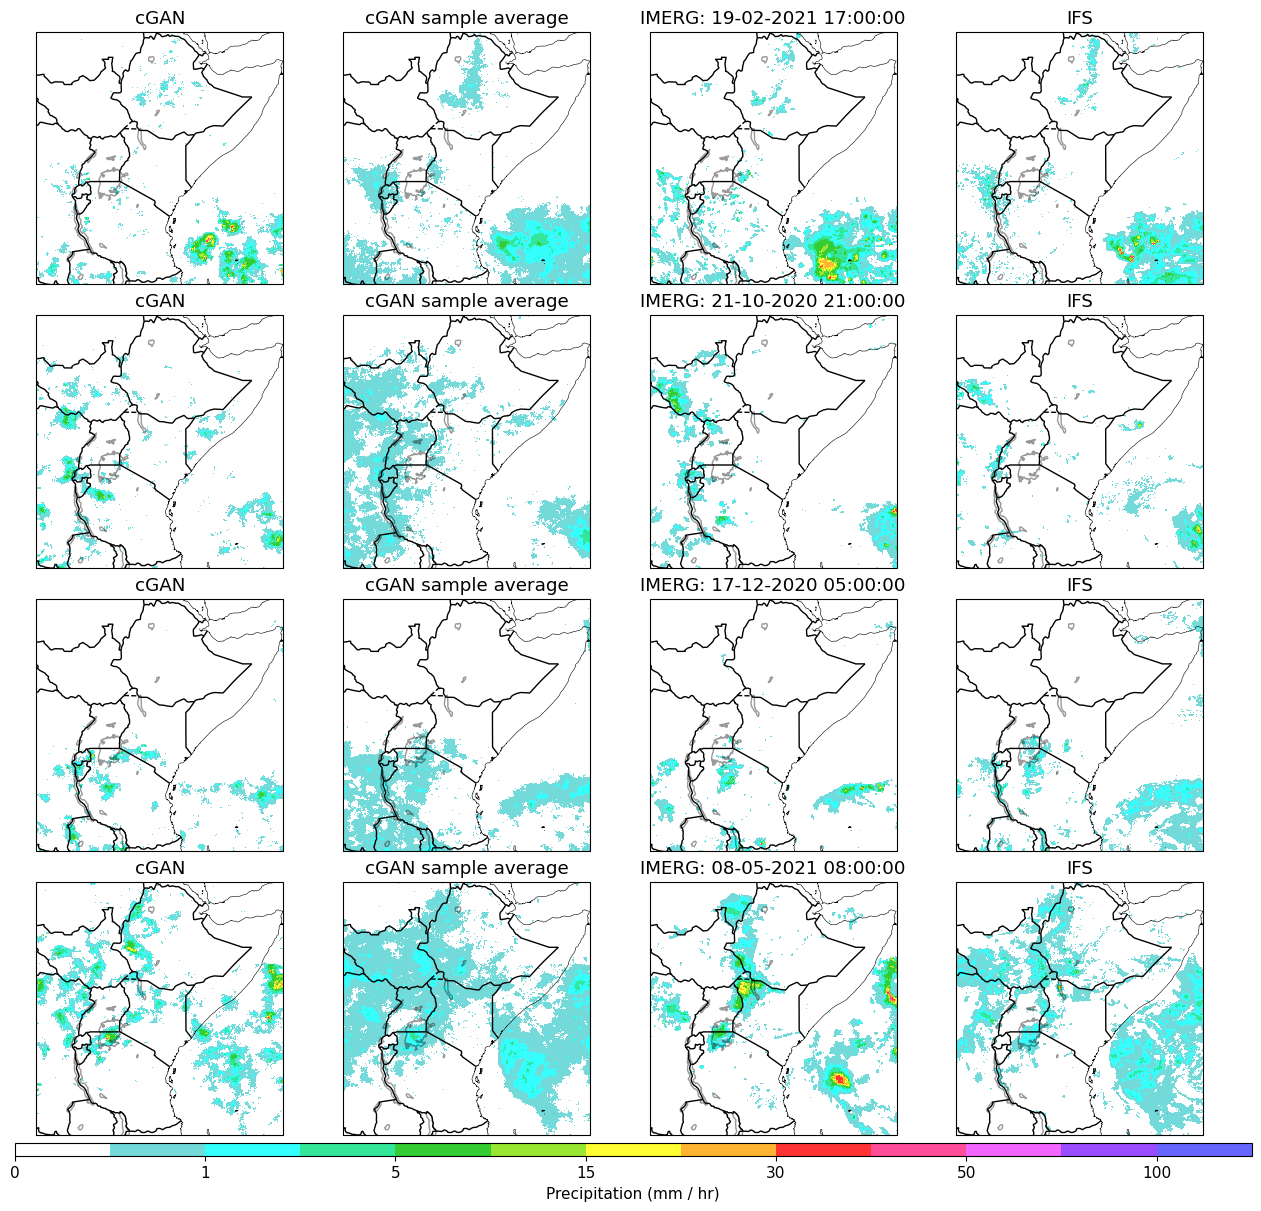

In [ ]:
from dsrnngan.data.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE, all_ifs_fields
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import random
from datetime import datetime, timedelta


# Find dry and rainy days in sampled dataset
means = [(n, truth_array[n,:,:].mean()) for n in range(n_samples)]
sorted_means = sorted(means, key=lambda x: x[1])

n_extreme_hours = 50
# wet_day_indexes = [item[0] for item in sorted_means[-n_extreme_hours:]]
# dry_day_indexes = [item[0] for item in sorted_means[:n_extreme_hours]]

tp_index = all_ifs_fields.index('tp')

# plot configurations
levels = [0, 0.1, 1, 2.5, 5, 10, 15, 20, 30, 40, 50, 70, 100, 150] # in units of log10
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(levels)-1], 'precipitation')
precip_norm = BoundaryNorm(levels, precip_cmap.N)

plt.rcParams.update({'font.size': 11})
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)

# indexes = np.random.choice(wet_day_indexes,10)
# indexes = np.random.choice(range(n_samples), 10)
# , datetime(2021,5,10,17,0,0)
all_datetimes = [date + timedelta(hours=hours[n]) for n, date in enumerate(dates)]
datetimes_to_plot = [datetime(2020,10,21,21,0,0), datetime(2020,12,17,5,0,0),datetime(2021,5,8,8,0,0), datetime(2021,2,19,17,0,0)]
indexes = [n for n, item in enumerate(all_datetimes) if item in datetimes_to_plot]


# + dry_day_indexes[:2]
num_cols = 5
num_samples = len(indexes)
num_rows = num_samples
# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', f'ifs_qmap_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows + 1, num_cols, figure=fig, 
                       width_ratios=[1]*(num_cols - 1) + [0.05],
                       height_ratios=[1]*(num_rows) + [0.05],
                       wspace=0.005)                      
for n in tqdm(range(len(indexes))):

    ix = indexes[n]
    img_gens = samples_gen_array[ix, :,:,:]
    truth = truth_array[ix,:,:]
    fcst = fcst_array[ix,:,:]
    fcst_corr = fcst_corrected[ix, :, :]
    date = dates[ix]
    hour = hours[ix]
    avg_img_gens = img_gens.mean(axis=-1)
    date_str = date.strftime('%d-%m-%Y') + f' {hour:02d}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[:,:,0], 'title': 'cGAN'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN sample average'},
                   'imerg' : {'title': f"IMERG: {date_str}", 'data': truth},
                   'ifs': {'data': fcst, 'title': 'IFS'},
                #    'ifs_qmap': {'data': fcst_corr, 'title': 'IFS + qmap'}
                # rr, 'title': 'IFS qmap'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[n, col], projection = ccrs.PlateCarree())
        im = plot_precipitation(ax, data=val['data'], title=val['title'], longitude_range=longitude_range, latitude_range=latitude_range)


# precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
# precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[-1, :])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                  )

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_xlabel("Precipitation (mm / hr)", loc='center')


plt.savefig(os.path.join(plot_dir, f'cGAN_samples_IFS_{model_type}_{model_number}.pdf'), format='pdf')

# Event-based metrics

In [ ]:
special_areas = {'All': {'lat_range': [min(latitude_range), max(latitude_range)], 'lon_range': [min(longitude_range), max(longitude_range)], 'abbrv': 'ALL'},
                 'Lake Victoria': {'lat_range': [-3.05,0.95], 'lon_range': [31.55, 34.55], 'abbrv': 'LV'},
                 'Somalia': {'lat_range': [-1.05,4.05], 'lon_range': [40.0, 44.05],  'abbrv': 'S'},
                 'S Sudan / S Ethiopia': {'lat_range': [4.35, 6.90], 'lon_range': [33.65, 36.9],  'abbrv': 'SSE'},
                 'Coast': {'lat_range': [-11.05, -4.70 ], 'lon_range': [38.0,39.0],  'abbrv': 'C'},
                 'West LV Basin': {'lat_range': [-4.70,0.30], 'lon_range': [29.5,31.3],  'abbrv': 'WLVB'},
                 'East LV Basin': {'lat_range': [-3.15, 1.55], 'lon_range': [34.5,36.0],  'abbrv': 'ELVB'},
           'NW Ethiopian Highlands': {'lat_range': [6.10, 14.15], 'lon_range': [34.60, 40.30], 'abbrv': 'NWEH'}

}


for k, v in special_areas.items():
    lat_vals = [lt for lt in lat_range_list if v['lat_range'][0] <= lt <= v['lat_range'][1]]
    lon_vals = [ln for ln in lon_range_list if v['lon_range'][0] <= ln <= v['lon_range'][1]]
    
    if lat_vals and lon_vals:
 
        special_areas[k]['lat_index_range'] = [lat_range_list.index(lat_vals[0]), lat_range_list.index(lat_vals[-1])]
        special_areas[k]['lon_index_range'] = [lon_range_list.index(lon_vals[0]), lon_range_list.index(lon_vals[-1])]

In [ ]:
from dsrnngan.data.data import load_land_sea_mask, filter_by_lat_lon
import xarray as xr 
lsm = xr.load_dataset('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/lsm_HRES_EAfrica.nc')

lon_limit = list(lsm['longitude'].values).index(38.75)

lake_mask = lsm.copy()
lake_mask['lsm'] = lsm['lsm'].copy()
lake_mask['lsm'][...,:,lon_limit-1:] = 1
lake_mask['lsm'] = np.abs(1 - lake_mask['lsm'])

sea_mask = lsm.copy()
sea_mask['lsm'] = lsm['lsm'].copy()
sea_mask['lsm'][...,:, :lon_limit-1] = 1
sea_mask['lsm'] = np.abs(1 - sea_mask['lsm'])

land_mask = lsm.copy()
land_mask['lsm'] = lsm['lsm'] + (1-lake_mask['lsm'])


lake_mask.to_netcdf('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/lake_mask.nc')
sea_mask.to_netcdf('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/sea_mask.nc')
land_mask.to_netcdf('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/land_mask.nc')


5it [01:49, 21.88s/it]


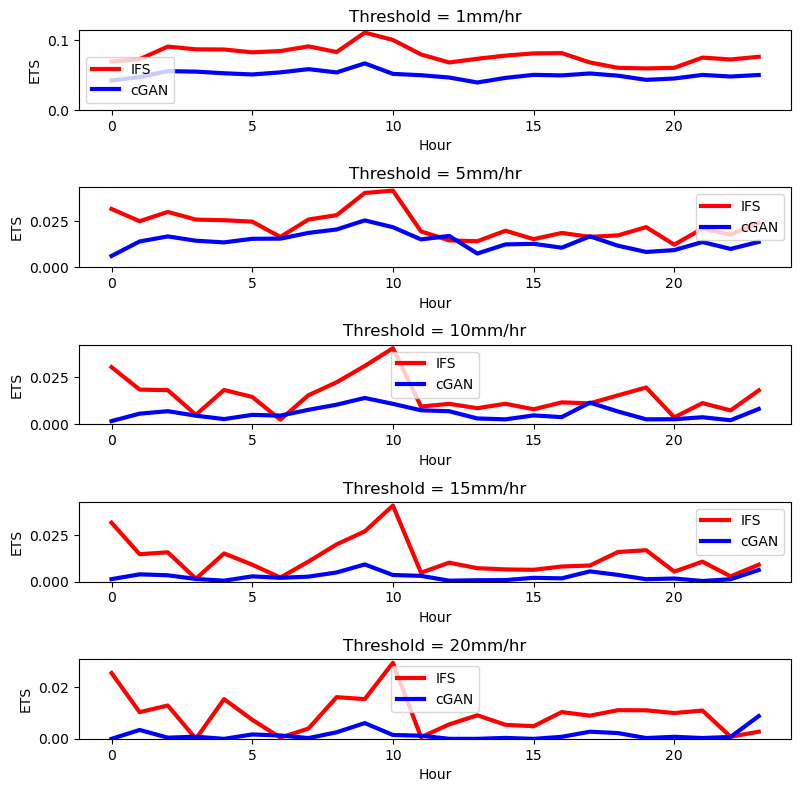

In [ ]:
from dsrnngan.evaluation.scoring import get_metric_by_grid_cell, get_metric_by_hour, equitable_threat_score, false_alarm_rate, hit_rate
from dsrnngan.data.data import load_land_sea_mask

# plot area results

thresholds = [1,5,10,15,20]
bin_width = 1
area = 'All'
area_range = special_areas[area]
lat_range_ends = area_range['lat_range']
lon_range_ends = area_range['lon_range']
lat_range_index = [area_range['lat_index_range'][0], area_range['lat_index_range'][-1] +1]
lon_range_index = [area_range['lon_index_range'][0], area_range['lon_index_range'][-1] +1]
lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.001, 0.1)
lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.001, 0.1)

fig, axs = plt.subplots(len(thresholds),1, figsize=(8, 8))
plot_keys = ['Fcst', 'GAN', 'GAN + qmap','Fcst + qmap']

format_lookup = {'cGAN': {'color': 'b'}, 'IFS': {'color': 'r'}
                 }

# mask = load_land_sea_mask('/bp1/geog-tropical/users/uz22147/east_africa_data/constants/sea_mask.nc',
#                           latitude_vals=lat_range,
#                           longitude_vals=lon_range)
# mask = (mask == 1)

metric = 'ETS'

metric_lookup = {'ETS': equitable_threat_score}

for n,thr in tqdm(enumerate(thresholds)):
    area_truth_array = truth_array[:,lat_range_index[0]:lat_range_index[1]+1, lon_range_index[0]:lon_range_index[1]+1]
    area_fcst_array = fcst_corrected[:,lat_range_index[0]:lat_range_index[1]+1, lon_range_index[0]:lon_range_index[1]+1]
    area_cgan_array = cgan_corrected[:,lat_range_index[0]:lat_range_index[1]+1, lon_range_index[0]:lon_range_index[1]+1, 0]

    metric_fn = lambda y_true, y_pred: metric_lookup[metric](y_true=y_true, y_pred=y_pred, threshold=thr)
    fcst_ets_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn=metric_fn, obs_array=area_truth_array, fcst_array=area_fcst_array, hours=hours, bin_width=bin_width)
    gan_ets_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn=metric_fn, obs_array=area_truth_array, fcst_array=area_cgan_array, hours=hours, bin_width=bin_width)

    axs[n].plot(np.array(list(fcst_ets_by_hour.values())), label='IFS', **format_lookup['IFS'], linewidth=3)

    axs[n].plot(np.array(list(gan_ets_by_hour.values())), label='cGAN', **format_lookup['cGAN'], linewidth=3)

    axs[n].set_title(f"Threshold = {thr}mm/hr")
    axs[n].legend()
    axs[n].set_ylim([0,None])
    axs[n].set_ylabel(metric)
    axs[n].set_xlabel('Hour')

fig.tight_layout(pad=1)
# plt.savefig(f'plots/{metric.lower()}_{area}_{model_type}_{model_number}.pdf'.replace(' ', '_'), foramt='pdf', bbox_inches='tight')

In [ ]:
hourly_thresholds = conf_mat_data['hourly_thresholds']
for thr in hourly_thresholds:
    conf_mat = [item for item in conf_mat_data['conf_mat'] if item['threshold'] == thr][0]
    total = conf_mat['ifs_qmap'].sum() 
    print(str(thr) + 10*'*' + '\n')
    print('IFS:\n')
    print(np.round(conf_mat['ifs_qmap']/total, 3))
    print('cGAN:\n')
    print(np.round(conf_mat['cgan_qmap']/total, 3))


0.1**********

IFS:

[[0.83  0.096]
 [0.043 0.031]]
cGAN:

[[0.88  0.047]
 [0.056 0.017]]
1**********

IFS:

[[0.956 0.022]
 [0.018 0.004]]
cGAN:

[[0.961 0.017]
 [0.019 0.002]]
5**********

IFS:

[[0.994 0.003]
 [0.003 0.   ]]
cGAN:

[[0.994 0.003]
 [0.003 0.   ]]
10**********

IFS:

[[0.999 0.001]
 [0.001 0.   ]]
cGAN:

[[0.999 0.001]
 [0.001 0.   ]]
20**********

IFS:

[[1. 0.]
 [0. 0.]]
cGAN:

[[1. 0.]
 [0. 0.]]


In [ ]:
conf_mat

{'threshold': 20,
 'ifs': array([[285081487,      6003],
        [    32355,       155]]),
 'cgan': array([[285070576,     16914],
        [    32443,        67]]),
 'cgan_qmap': array([[285052884,     34606],
        [    32398,       112]]),
 'ifs_qmap': array([[285052266,     35224],
        [    31874,       636]])}

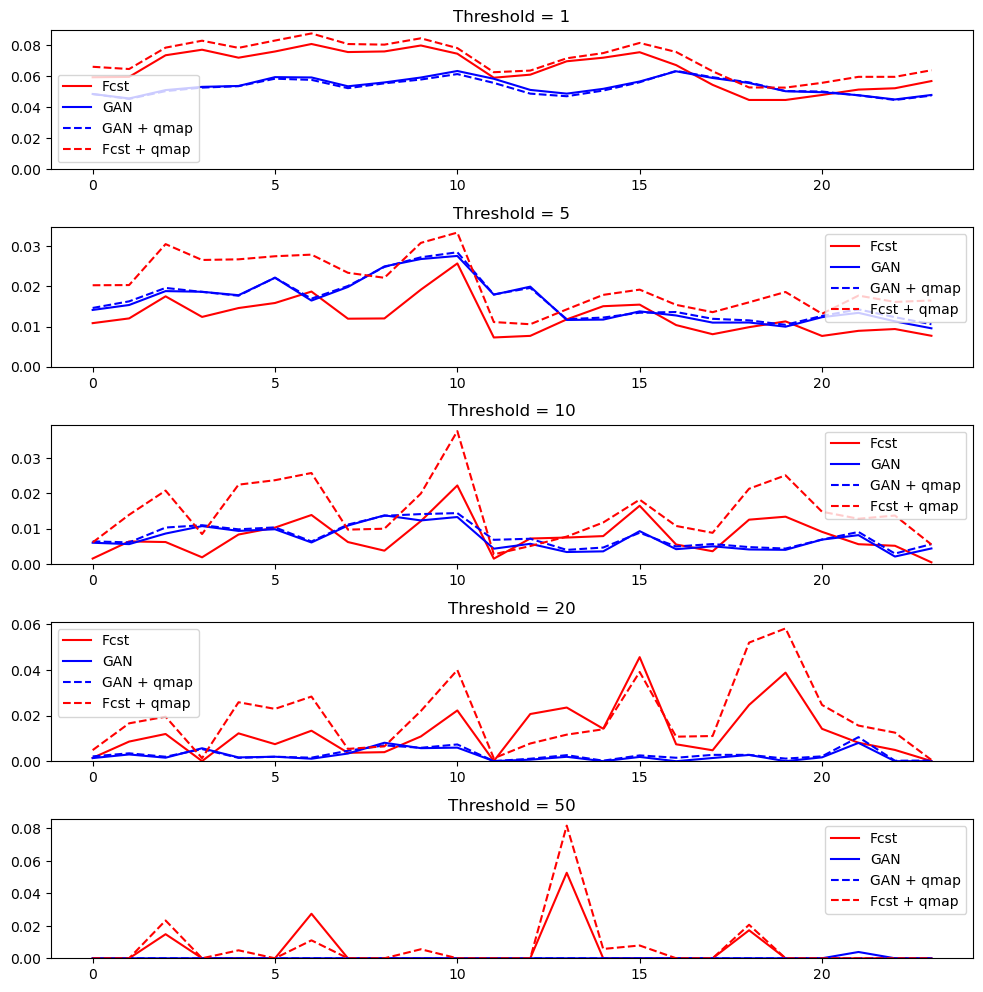

In [ ]:
fig, axs = plt.subplots(len(csi_data),1, figsize=(10, 10))
plot_keys = ['Fcst', 'GAN', 'GAN + qmap','Fcst + qmap']

format_lookup = {'GAN': {'color': 'b'}, 'Fcst': {'color': 'r'}, 'GAN + qmap': {'color': 'b', 'linestyle': '--'}, 'Fcst + qmap': {'color': 'r', 'linestyle': '--'}}

for n in range(len(ets_data)):
    for pk in plot_keys:
        axs[n].plot(ets_data[n][pk + '_hourly'][0].values(), label=pk, **format_lookup[pk])
        axs[n].set_title(f"Threshold = {csi_data[n]['threshold']}")
    axs[n].legend()
    axs[n].set_ylim([0,None])

fig.tight_layout(pad=1)

In [ ]:
# ETS by grid cell

from dsrnngan.evaluation.scoring import get_csi_by_grid_cell

In [ ]:
from dsrnngan.evaluation.scoring import get_metric_by_hour, get_metric_by_grid_cell, equitable_threat_score

threshold = 5
bin_width=3
area = 'Lake Victoria'
area_range = special_areas[area]
lat_range_ends = area_range['lat_range']
lon_range_ends = area_range['lon_range']
lat_range_index = [area_range['lat_index_range'][0], area_range['lat_index_range'][-1] +1]
lon_range_index = [area_range['lon_index_range'][0], area_range['lon_index_range'][-1] +1]
lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.001, 0.1)
lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.001, 0.1)

area_truth_array = truth_array[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]
metric_fn = lambda y_true, y_pred: get_metric_by_grid_cell(metric_fn=equitable_threat_score, y_true=y_true, y_pred=y_pred, threshold=threshold)
fcst_ets_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn=metric_fn, obs_array=truth_array[:,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1], 
                                                      fcst_array=fcst_corrected[:,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1], hours=hours, bin_width=bin_width)
gan_ets_by_hour, _ = get_metric_by_hour(metric_fn=metric_fn, obs_array=truth_array[:,lat_range_index[0]:lat_range_index[-1]+1, 
                                                                                   lon_range_index[0]:lon_range_index[-1]+1], 
                                        fcst_array=cgan_corrected[:,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1,0], hours=hours, bin_width=bin_width)



TypeError: Length of x (31) must match number of columns in z (32)

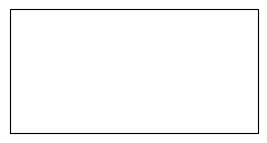

In [ ]:
from dsrnngan.evaluation.scoring import equitable_threat_score
from dsrnngan.evaluation.plots import plot_contourf
from scipy.ndimage import uniform_filter
n_rows = 2
n_cols = int(np.ceil(len(fcst_ets_by_hour)/n_rows))

fig = plt.figure(constrained_layout=True, figsize=(2.5*n_cols, 3*n_rows))
gs = gridspec.GridSpec(n_rows + 1, n_cols, figure=fig, 
                    width_ratios=[1]*(n_cols ),
                    height_ratios=[1]*(n_rows) + [0.05],
                wspace=0.005)  
    
digitized_hours = np.digitize(hours, bins=hour_bin_edges)

for n, hour_ix in enumerate(fcst_ets_by_hour):
    row = int(n / n_cols)
    column = n % n_cols
    ax = fig.add_subplot(gs[row, column], projection = ccrs.PlateCarree())

    hour_indexes = np.where(np.array(digitized_hours) == hour_ix)[0]

    if n == max(fcst_ets_by_hour)-1:
        hr_end = 24
    else:
        hr_end = hour_bin_edges[n+1]-1
    bias = gan_ets_by_hour[hour_ix] -fcst_ets_by_hour[hour_ix]
    smoothed_bias = uniform_filter(np.nan_to_num(bias,0), size=1, mode='reflect')
    
    im = plot_contourf(bias, f"{hour_bin_edges[n]:02d}-{hr_end:02d}h EAT", ax=ax, value_range=np.arange(-0.1,0.11,0.01), 
                lon_range=lon_range, 
                lat_range=lat_range,
                    cmap='RdBu', extend='both', add_borders=False)


cbar_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                )
cb.ax.set_xlabel("ETS(GAN) - ETS(IFS)", 
                 loc='center')
plt.savefig(f'plots/ets_by_hour_thr{threshold}_{area}_{model_type}_{model_number}.pdf', format='pdf')

### Confusion matrics

In [ ]:
with open('/user/home/uz22147/repos/downscaling-cgan/plots/n4000_202010-202109_45682_e20/confusion_matrices_cl100-medium-nologs_217600.pkl', 'rb') as ifh:
    results = pickle.load(ifh)

In [ ]:
[item for item in results['conf_mat'] if item['threshold'] == 30]

[{'threshold': 30,
  'cgan_qmap': array([[285102446,      9478],
         [     8062,        14]]),
  'ifs_qmap': array([[285100816,     11108],
         [     7997,        79]]),
  'cgan_ens': array([[285111924,         0],
         [     8076,         0]])}]

In [13]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
n_samples = 1000
# quantile_locations = [0.1, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999]
# hourly_thresholds = np.quantile(truth_array, quantile_locations)
hourly_thresholds = [0.1, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

results = {'hourly_thresholds': hourly_thresholds,
            'conf_mat': []}
area = 'Lake Victoria'
area_range = special_areas[area]
lat_range_ends = area_range['lat_range']
lon_range_ends = area_range['lon_range']
lat_range_index = [area_range['lat_index_range'][0], area_range['lat_index_range'][-1] +1]
lon_range_index = [area_range['lon_index_range'][0], area_range['lon_index_range'][-1] +1]
lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.001, 0.1)
lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.001, 0.1)

for threshold in tqdm(hourly_thresholds):
    y_true = (truth_array[:n_samples,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1] > threshold).astype(np.int0).flatten()

    y_dict = {
            'cgan_qmap' : (cgan_corrected[:n_samples,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1,0]> threshold).astype(np.int0).flatten(),
            'ifs_qmap': (fcst_corrected[:n_samples,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1] > threshold).astype(np.int0).flatten(),
            'cgan_ens': (np.mean(cgan_corrected, axis=-1)[:n_samples,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1]> threshold).astype(np.int0).flatten()}

    tmp_results_dict = {'threshold': threshold}
    for k, v in tqdm(y_dict.items()):
        tmp_results_dict[k] = confusion_matrix(y_true, v)
    results['conf_mat'].append(tmp_results_dict)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [02:43<00:00, 13.62s/it]


In [14]:
# plot ETS , FAR, Hit Rate as function of thresholds
from dsrnngan.evaluation import scoring
hourly_thresholds = results['hourly_thresholds']
ets_vals = {}
hit_rate_vals = {}
far_vals = {}
pss_vals = {}
for source in ['ifs_qmap', 'cgan_qmap', 'cgan_ens']:
    ets_vals[source] = []
    hit_rate_vals[source] = []
    far_vals[source] = []
    pss_vals[source] = []
    for thr in hourly_thresholds:
        
        conf_mat = [item for item in results['conf_mat'] if item['threshold'] == thr][0]
        total = conf_mat[source].sum() 
        
        hits = conf_mat[source][1,1]
        misses = conf_mat[source][1,0]
        false_alarms = conf_mat[source][0,1]
        correct_negatives = conf_mat[source][0,0]

        hits_random = (hits + misses)*(hits + false_alarms) / conf_mat[source].sum()
        ets_vals[source].append((hits -hits_random ) / (hits + misses + false_alarms - hits_random))
        
        hit_rate = (hits ) / (hits + misses)
        false_alarm_rate = (false_alarms) / (hits + misses + false_alarms)
        hit_rate_vals[source].append(hit_rate)
        far_vals[source].append(false_alarm_rate)
        pss_vals[source].append(hit_rate - false_alarm_rate)



Text(0, 0.5, 'Peirce Skill Score')

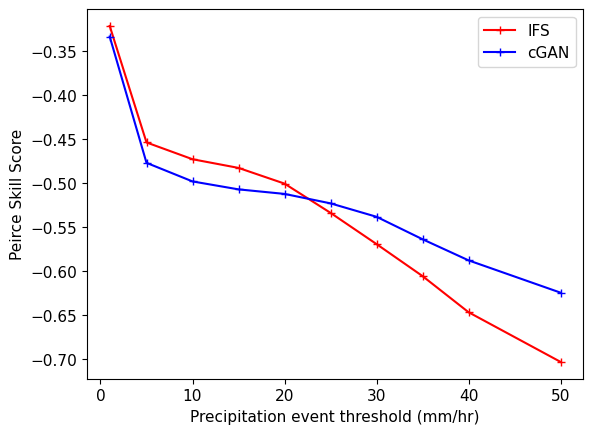

In [ ]:
fig, ax = plt.subplots(1,1)

format_lookup = {'ifs_qmap': {'label': 'IFS', 'color': 'r'}, 'cgan_qmap':  {'label': 'cGAN', 'color': 'b'}}

for source in ['ifs_qmap', 'cgan_qmap']:
    ax.plot(hourly_thresholds[:-1], pss_vals[source][:-1], '+-', color=format_lookup[source]['color'], label=format_lookup[source]['label'])
ax.legend()
ax.set_xlabel('Precipitation event threshold (mm/hr)')
ax.set_ylabel('Peirce Skill Score')

Text(0, 0.5, 'Equitable Threat Score')

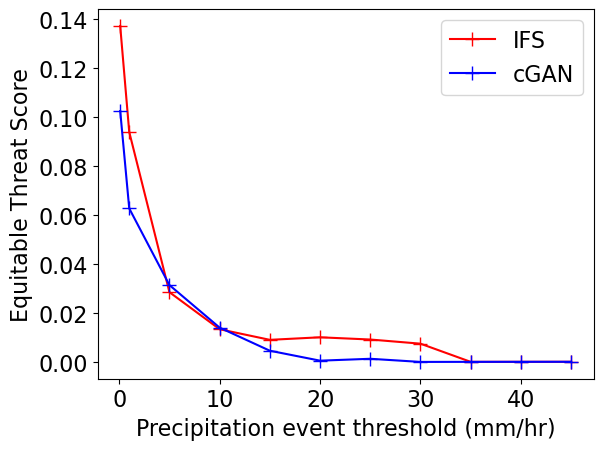

In [15]:
fig, ax = plt.subplots(1,1)

format_lookup = {'ifs_qmap': {'label': 'IFS', 'color': 'r'}, 'cgan_qmap':  {'label': 'cGAN', 'color': 'b'}}

for source in ['ifs_qmap', 'cgan_qmap']:
    ax.plot(hourly_thresholds[:-1], ets_vals[source][:-1], '+-', color=format_lookup[source]['color'], label=format_lookup[source]['label'],markersize=10)
ax.legend()
ax.set_xlabel('Precipitation event threshold (mm/hr)')
ax.set_ylabel('Equitable Threat Score')
# plt.savefig(os.path.join(plot_dir, f'ets_{model_type}_{model_number}.pdf'), format='pdf', bbox_inches='tight')


Text(0.5, 0, 'Precipitation event threshold (mm/hr)')

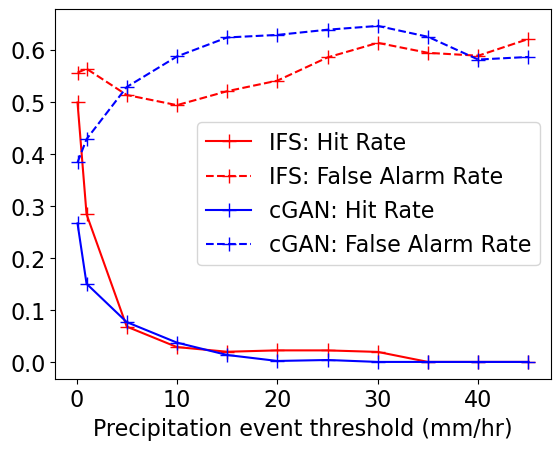

In [16]:
fig, ax = plt.subplots(1,1)

format_lookup = {'ifs_qmap': {'label': 'IFS', 'color': 'r'}, 'cgan_qmap':  {'label': 'cGAN', 'color': 'b'}}

for source in ['ifs_qmap', 'cgan_qmap']:
    ax.plot(hourly_thresholds[:-1], hit_rate_vals[source][:-1], '+-', 
            color=format_lookup[source]['color'], 
            label=format_lookup[source]['label'] + ': Hit Rate',markersize=10)
    ax.plot(hourly_thresholds[:-1], far_vals[source][:-1], 
            '+--', 
            color=format_lookup[source]['color'], 
            label=format_lookup[source]['label']+ ': False Alarm Rate',markersize=10)

ax.legend()
ax.set_xlabel('Precipitation event threshold (mm/hr)')
# plt.savefig(os.path.join(plot_dir, f'hit_rate_{model_type}_{model_number}.pdf'), format='pdf', bbox_inches='tight')

# Rainfall scatter plot

In [ ]:
from scipy.stats import binned_statistic

binned_cgan_mean, bin_edges, _ = binned_statistic(truth_array.flatten(), cgan_corrected[...,0].flatten(), statistic='mean', bins=100, range=None)
binned_fcst_mean, bin_edges, _ = binned_statistic(truth_array.flatten(), fcst_corrected.flatten(), statistic='mean', bins=100, range=None)
binned_obs_mean, bin_edges, _ = binned_statistic(truth_array.flatten(), truth_array.flatten(), statistic='mean', bins=100, range=None)

NameError: name 'truth_array' is not defined

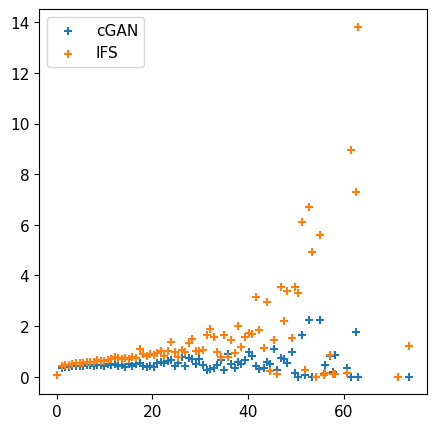

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(binned_obs_mean, binned_cgan_mean, label='cGAN', marker='+')
ax.scatter(binned_obs_mean, binned_fcst_mean, label='IFS',  marker='+')
# ax.plot(binned_obs_mean, binned_obs_mean, linestyle='--', color='b')
ax.legend()

<matplotlib.legend.Legend>

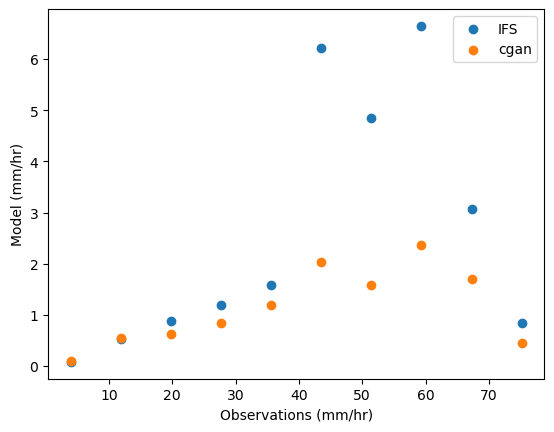

In [ ]:
h = np.histogram(truth_array, 10)
bin_edges = h[1]
bin_edges[0] = 0
bin_centres = [0.5*(bin_edges[n] + bin_edges[n+1]) for n in range(len(bin_edges) - 1)]

mean_data = {}
data_dict = {'IFS': fcst_corrected,
             'cGAN': cgan_corrected}

for name, d in data_dict.items():
    
    mean_data[name] = []
    for n in range(len(bin_edges) - 1):
        valid_ix = np.logical_and(truth_array <=bin_edges[n+1], truth_array >= bin_edges[n])
        tmp_fcst_data = d[valid_ix]
        assert tmp_fcst_data.size > 0
        mean_data[name].append(tmp_fcst_data.mean())
        
fig, ax = plt.subplots(1,1)

for name, d in mean_data.items():
    ax.scatter(bin_centres, d, label=name)
ax.set_xlabel('Observations (mm/hr)')
ax.set_ylabel('Model (mm/hr)')
ax.legend()

# Reliability diagnostics

### Spread error relationship

In [ ]:
from dsrnngan.evaluation.scoring import get_spread_error_data

binned_mse, binned_spread = get_spread_error_data(n_samples=4000, observation_array=truth_array, ensemble_array=samples_gen_array, 
                                                n_bins=100)
if np.isnan(binned_spread[0]):
    binned_spread = binned_spread[1:]
    binned_mse = binned_mse[1:]


In [33]:
ensemble_data_dir = '/user/home/uz22147/repos/downscaling-cgan/plots/n1000_202010-202109_45682_e100'
with open(os.path.join(ensemble_data_dir,'spread_error_cl100-medium-nologs_217600.pkl'), 'rb') as ifh:
    se_data = pickle.load(ifh)
binned_spread = se_data['binned_spread']
binned_mse = se_data['binned_mse']

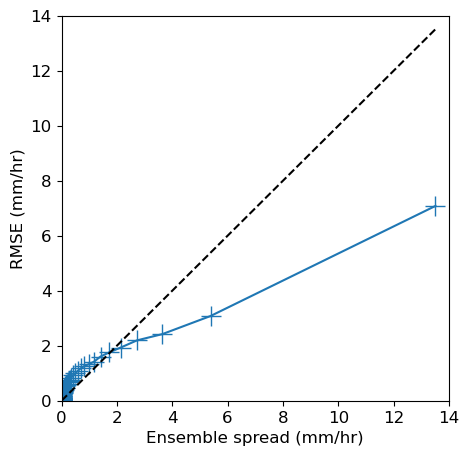

In [34]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
plt.rcParams.update({'font.size': 12})
ax.plot(binned_spread, binned_mse, marker='+', markersize=15)
ax.plot(np.linspace(0,max(binned_spread),10), 
        np.linspace(0,max(binned_spread),10), 'k--')
ax.set_ylabel('RMSE (mm/hr)')
ax.set_xlabel('Ensemble spread (mm/hr)')
ax.set_xlim([0,14])
ax.set_ylim([0,14])
ax.set_xticks(np.arange(0,15,2))
plt.savefig(os.path.join(ensemble_data_dir, f'spread_error_{model_type}_{model_number}.pdf'), format='pdf')

In [ ]:
os.path.join(ensemble_data_dir, f'spread_error_{model_type}_{model_number}.pdf')

'/user/home/uz22147/repos/downscaling-cgan/plots/n1000_202010-202109_45682_e100/spread_error_final-nologs_217600.pdf'

## Rank histogram

In [ ]:
from pysteps.verification.ensscores import rankhist

Text(0.5, 0, 'Normalised rank')

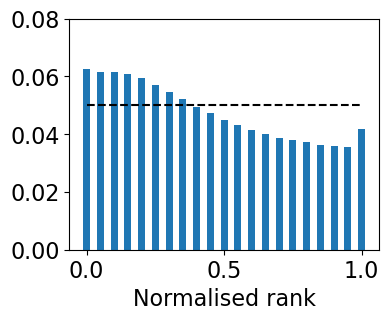

In [ ]:

result = rankhist(np.moveaxis(cgan_corrected[:100,...], -1, 0), truth_array[:100,...], normalize=True)


In [10]:
with open('/user/home/uz22147/repos/downscaling-cgan/plots/n1000_202010-202109_45682_e100/ranks_cl100-medium-nologs_217600.pkl', 'rb') as ifh:
    ranks = pickle.load(ifh)

In [12]:
plot_dir

'/user/home/uz22147/repos/downscaling-cgan/plots/n4000_202010-202109_45682_e20'

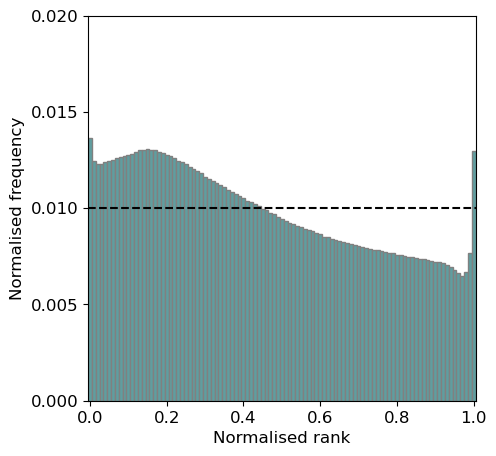

In [31]:
ranks_ensemble_size = 100

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.bar(np.linspace(0,1,ranks_ensemble_size+1), ranks, width=1/ranks_ensemble_size, 
       color='cadetblue', edgecolor='grey')
ax.set_ylim([0,0.02])
ax.set_xlim([0-0.5/ranks_ensemble_size,1+0.5/ranks_ensemble_size])

ax.hlines(1/ranks_ensemble_size, 0-0.5/ranks_ensemble_size,1+0.5/ranks_ensemble_size, linestyles='dashed', colors=['k'])
ax.set_xlabel('Normalised rank')
ax.set_ylabel('Normalised frequency')
ax.set_yticks(np.arange(0,0.0205,0.005))
plt.savefig(os.path.join('/user/home/uz22147/repos/downscaling-cgan/plots/n1000_202010-202109_45682_e100/',f'rank_hist__{model_type}_{model_number}.pdf'), format='pdf', bbox_inches='tight')

# RAPSD

In [ ]:
from dsrnngan.evaluation.evaluation import calculate_ralsd_rmse

In [ ]:
ralsd_rmse_all = []
for ix in tqdm(range(truth_array.shape[0])):
    ralsd_rmse = calculate_ralsd_rmse(truth_array[ix:ix+1, ...], samples_gen_array[ix:ix+1,..., 0])
    ralsd_rmse_all.append(ralsd_rmse.flatten())

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:56<00:00, 71.30it/s]


In [ ]:
from dsrnngan.evaluation.scoring import mse
ralsd_rmse_all = []
for ix in tqdm(range(truth_array.shape[0])):
    fft_freq_truth = rapsd(truth_array[ix,:,:], fft_method=np.fft)
    fft_freq_pred = rapsd(samples_gen_array[ix,:,:,0], fft_method=np.fft)
    
    ralsd_rmse_all.append(mse(fft_freq_truth, fft_freq_pred))

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:55<00:00, 71.53it/s]


In [ ]:
from dsrnngan.evaluation.rapsd import rapsd

rapsd_data_dict = {
                    'GAN': {'data': cgan_corrected[:, :, :, 0], 'color': 'b', 'linestyle': '-'},
                    'Obs (IMERG)': {'data': truth_array, 'color': 'k', 'linestyle': '-'},
                    'IFS': {'data': fcst_corrected, 'color': 'r', 'linestyle': '-'},
                    }

rapsd_results = {}
for k, v in rapsd_data_dict.items():
        rapsd_results[k] = []
        for n in tqdm(range(n_samples)):
        
                fft_freq_pred = rapsd(v['data'][n,:,:], fft_method=np.fft)
                rapsd_results[k].append(fft_freq_pred)

        rapsd_results[k] = np.mean(np.stack(rapsd_results[k], axis=-1), axis=-1)

  0%|          | 1/4000 [00:00<07:46,  8.58it/s]

100%|██████████| 4000/4000 [00:32<00:00, 122.87it/s]


In [ ]:
rapsd_results['cGAN']

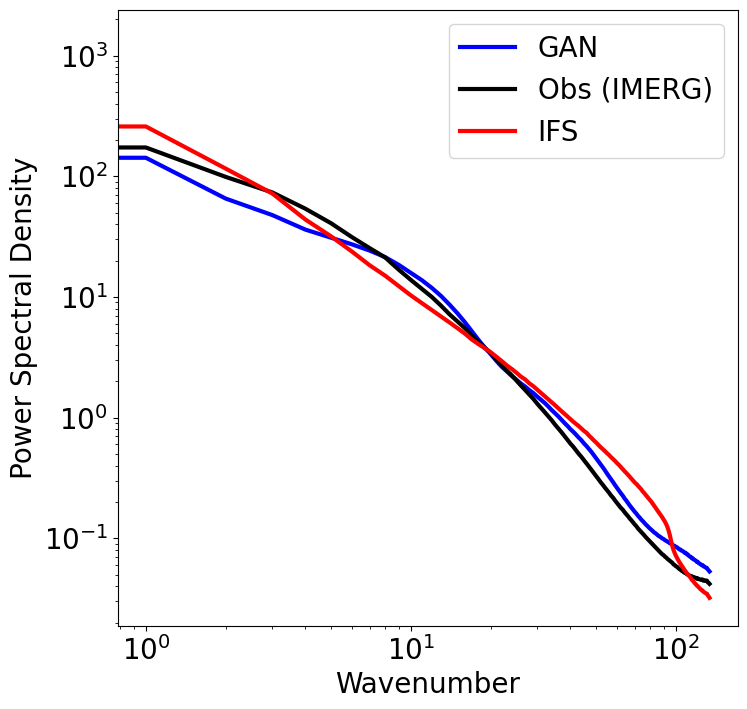

In [ ]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1,1, figsize=(8,8))

for k, v in rapsd_results.items():
    ax.plot(v, label=k, color=rapsd_data_dict[k]['color'], linestyle=rapsd_data_dict[k]['linestyle'], linewidth=3)
    
plt.xscale('log')
plt.yscale('log')
ax.set_ylabel('Power Spectral Density')
ax.set_xlabel('Wavenumber')
ax.legend()

plt.savefig(os.path.join(plot_dir, f'rapsd_{model_type}_{model_number}.pdf'), format='pdf', bbox_inches='tight')

## Quantiles

In [ ]:
from dsrnngan.evaluation.plots import range_dict, get_quantile_data
quantile_data_dict = {
                    'cGAN': samples_gen_array[:, :, :, 0],
                    'cGAN + qmap': cgan_corrected[:, :, :, 0],
                    'Obs (IMERG)': truth_array,
                    'IFS': fcst_array,
                    'IFS + qmap': fcst_corrected,
                    }
range_dict_truncated = range_dict.copy()
range_dict_truncated = {}
quantile_results, quantile_boundaries, intervals = get_quantile_data(quantile_data_dict,save_path=None,range_dict=range_dict)

100%|██████████| 9/9 [00:49<00:00,  5.53s/it]


In [ ]:
with open(os.path.join(plot_dir,'quantiles_total_final-nologs_217600.pkl'), 'rb') as ifh:
    quantile_results= pickle.load(ifh)['quantile_results']

quantile_results_truncated = {}
for k, v in quantile_results.items():
    quantile_results_truncated[k] = {}

    for ix, qs in v.items():
        if ix <8:
            
            quantile_results_truncated[k][ix] = qs
    

In [ ]:
from itertools import chain

quantile_results_unravelled = {}
for name, data_dict in quantile_results_truncated.items():
    quantile_results_unravelled[name]=list(chain.from_iterable([v for v in quantile_results_truncated[name].values()]))

In [ ]:
# Get bootstrap results
with open(os.path.join(log_folder, f'bootstrap_quantile_results_n1000.pkl'), 'rb') as ifh:
    bstrap_results = pickle.load(ifh)
    
bootstrap_results_dict_fcst_qmap = bstrap_results['fcst']
bootstrap_results_dict_obs = bstrap_results['obs']
bootstrap_results_dict_cgan_qmap = bstrap_results['cgan']

# calculate standard deviation and mean of
quantile_locations = [np.round(1 - 10**(-n),n+1) for n in range(3, 9)]
def calculate_quantiles(input_array, quantile_locations=quantile_locations):
    return np.quantile(input_array, quantile_locations)
fcst_quantiles = calculate_quantiles(fcst_corrected)
cgan_quantiles = calculate_quantiles(cgan_corrected[:,:,:,0])
obs_quantiles = calculate_quantiles(truth_array)

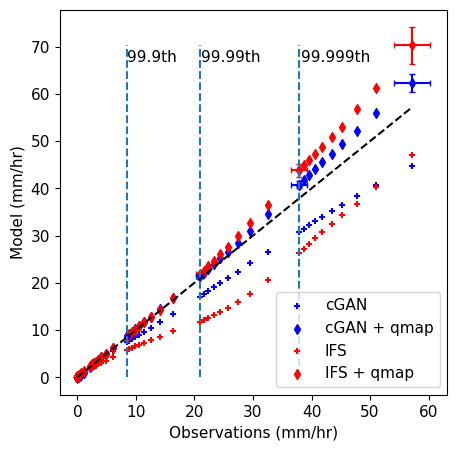

In [ ]:
format_lookup = {'cGAN': {'color': 'b', 'marker': '+', 'alpha': 1},
                    'Obs (IMERG)': {'color': 'k'},
                    'IFS': {'color': 'r', 'marker': '+', 'alpha': 1},
                    'IFS + qmap': {'color': 'r', 'marker': 'd', 'alpha': 0.7},
                    'cGAN + qmap': {'color': 'b', 'marker': 'd', 'alpha': 0.7}}
plt.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(1,1, figsize=(5,5))
max_truth_val = max(quantile_results_unravelled['Obs (IMERG)'])
max_quantile = 0.9999999
quantile_annotation_dict = {str(np.round(q, 11)): np.quantile(quantile_data_dict['Obs (IMERG)'], q) for q in [1 - 10**(-n) for n in range(3, 6)] if q <=max_quantile}

for data_name, results in quantile_results_unravelled.items():
   if data_name != 'Obs (IMERG)':
      s = ax.scatter(quantile_results_unravelled['Obs (IMERG)'], 
                                       results, 
                                       c=format_lookup[data_name]['color'],
                                       marker=format_lookup[data_name]['marker'], 
                                       label=data_name,
                                       s=25)
ax.errorbar(obs_quantiles[:-2], fcst_quantiles[:-2], yerr=2*bootstrap_results_dict_fcst_qmap['std'][:-2], 
            xerr=2*bootstrap_results_dict_obs['std'][:-2], 
            capsize=2, ls='none', ecolor='r')
ax.errorbar(obs_quantiles[:-2], cgan_quantiles[:-2], 
            yerr=2*bootstrap_results_dict_cgan_qmap['std'][:-2], 
            xerr=2*bootstrap_results_dict_obs['std'][:-2],
            capsize=2, ls='none', ecolor='b')         

ax.plot(np.linspace(0, max_truth_val, 100), np.linspace(0, max_truth_val, 100), 'k--')
ax.set_xlabel('Observations (mm/hr)')
ax.set_ylabel('Model (mm/hr)')
ax.legend(loc='lower right')

# find largest value
max_val = 0
for v in quantile_results_unravelled.values():
   if max(v) > max_val:
      max_val = max(v)
                
for k, v in quantile_annotation_dict.items():
   ax.vlines(v, 0, max_val, linestyles='--')
   ax.text(1.01*v, 0.95* max_val, f'{np.round(float(k)*100, 12)}th')
plt.savefig(os.path.join(plot_dir, f'quantiles_total_{model_type}_{model_number}.pdf'), format='pdf', bbox_inches='tight')

In [ ]:
os.path.join(plot_dir, f'quantiles_total_{model_type}_{model_number}.pdf')

'/user/home/uz22147/repos/downscaling-cgan/plots/n4000_202010-202109_45682_e20/quantiles_total_final-nologs_217600.pdf'

100%|██████████| 9/9 [00:00<00:00, 343.04it/s]


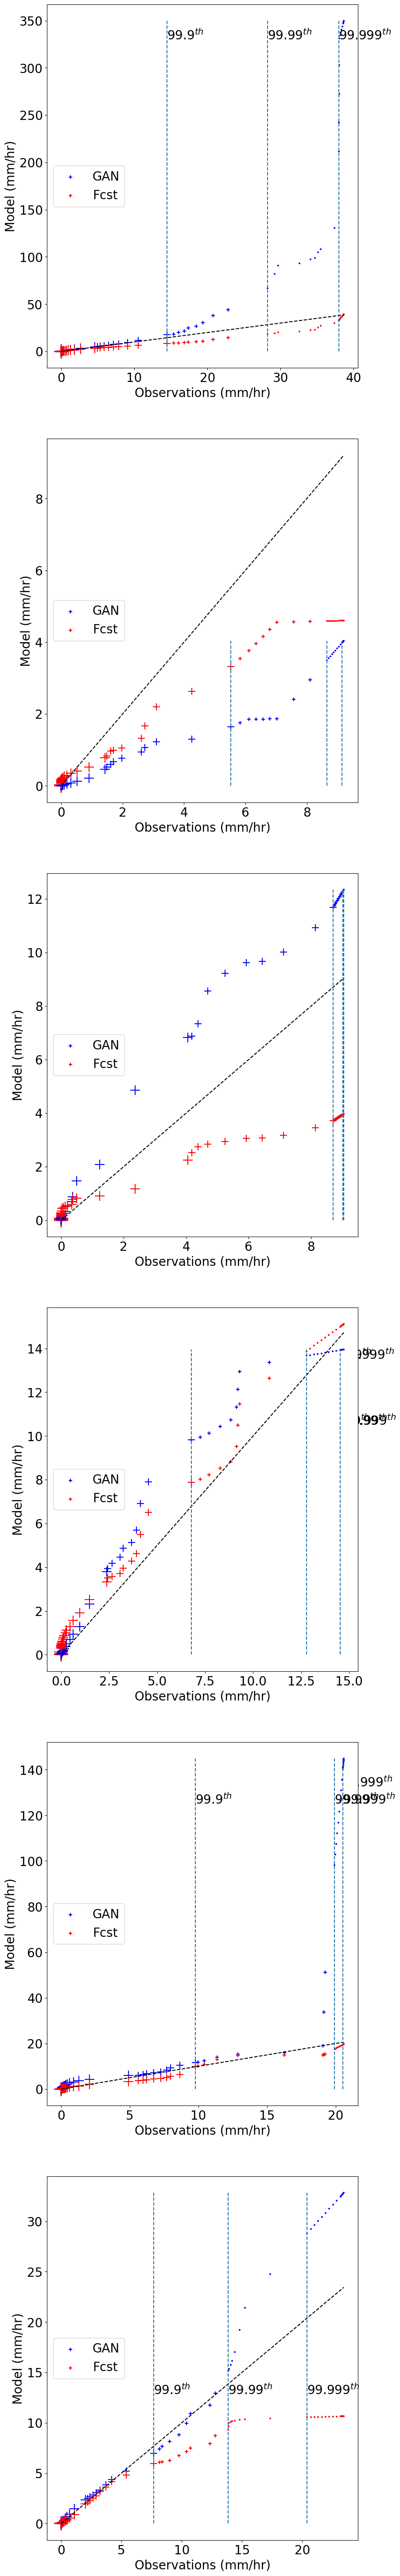

In [ ]:
# Quantiles for different areas
import copy


fig, ax = plt.subplots(max(2, len(special_areas)),1, figsize=(10, len(special_areas)*10))
fig.tight_layout(pad=4)
for n, (area, area_range) in enumerate(special_areas.items()):


    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    
    local_quantile_data_dict = {}
    for k, v in quantile_data_dict.items():
        local_quantile_data_dict[k] = copy.deepcopy(v)
        local_quantile_data_dict[k]['data'] = local_quantile_data_dict[k]['data'][:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]]
    
    
    plot_quantiles(local_quantile_data_dict, ax=ax[n])
    ax[n].set_title(area)

## Histograms

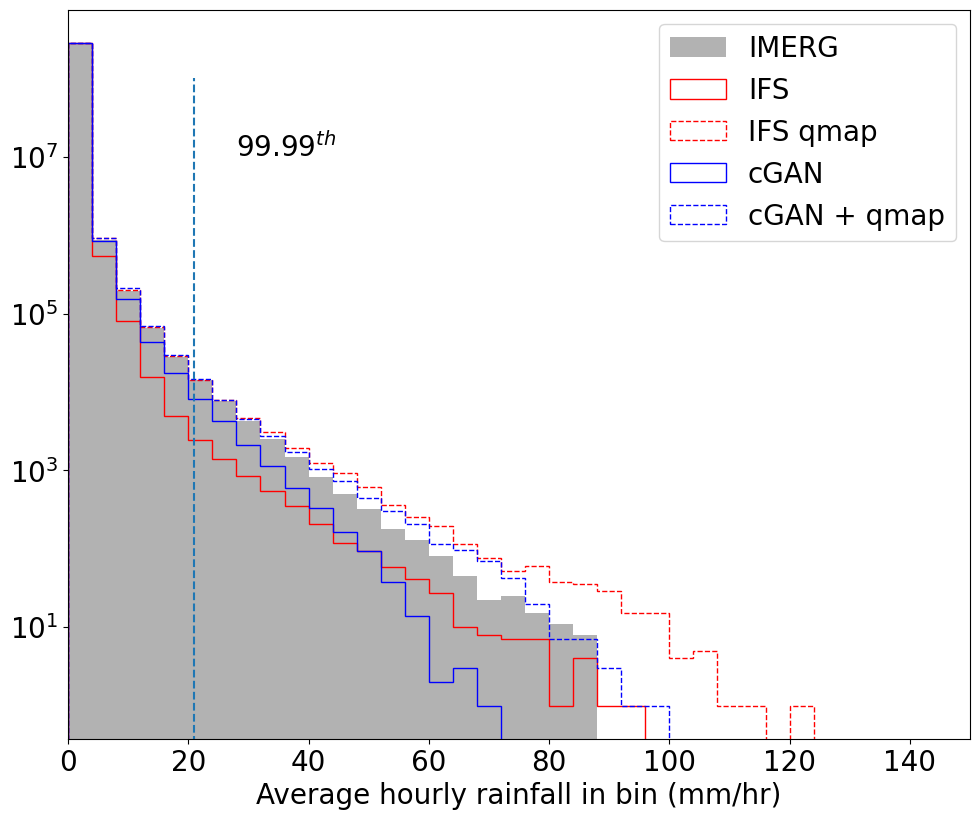

In [ ]:
from itertools import chain

(q_99pt9, q_99pt99) = np.quantile(truth_array, [0.999, 0.9999])

plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(1,1, figsize=(12,10))
fig.tight_layout(pad=4)
bin_boundaries=np.arange(0,300,4)

data_dict = {'IMERG': {'data': truth_array, 'histtype': 'stepfilled', 'alpha':0.6, 'facecolor': 'grey'}, 
             'IFS': {'data': fcst_array, 'histtype': 'step', 'edgecolor': 'red'},
             'IFS qmap': {'data': fcst_corrected, 'histtype': 'step', 'edgecolor': 'red', 'linestyle': '--'},
             'cGAN': {'data': samples_gen_array[:,:,:,0], 'histtype': 'step', 'edgecolor': 'blue'},
                'cGAN + qmap': {'data': cgan_corrected[...,0], 'histtype': 'step', 'edgecolor': 'blue', 'linestyle': '--'}}
rainfall_amounts = {}

edge_colours = ["blue", "green", "red", 'orange']
for n, (name, d) in enumerate(data_dict.items()):
    # (bin_count, bin_values) = np.histogram(d['data'].flatten(), bins=bin_boundaries)
    
    axs.hist(d['data'].flatten(), bins=bin_boundaries, histtype=d['histtype'], label=name, alpha=d.get('alpha'),
                facecolor=d.get('facecolor'), edgecolor=d.get('edgecolor'), linestyle= d.get('linestyle'))
    
    
    # axs[1].hist(d['data'].flatten(), bins=bin_boundaries, histtype=d['histtype'], label=name, weights=d['data'].flatten(), alpha=d.get('alpha'),
    #             facecolor=d.get('facecolor'), edgecolor=d.get('edgecolor'), linestyle= d.get('linestyle'))

      

axs.set_yscale('log')
axs.legend()
axs.set_xlabel('Average hourly rainfall in bin (mm/hr)')
axs.set_xlim([0,150])
# ax.vlines(q_99pt9, 0, 10**8, linestyles='--')
axs.vlines(q_99pt99, 0, 10**8, linestyles='--')
# ax.text(q_99pt9 - 5, 10**8 - 20, '$99.9^{th}$')
axs.text(q_99pt99 + 7 , 10**7, '$99.99^{th}$')
# ax.set_ylabel('Total amount of rainfall in bin (mm/hr)')
plt.savefig(os.path.join(plot_dir, f'histograms_{model_type}_{model_number}.pdf'), format='pdf', bbox_inches='tight')


## Long term average and std for IMERG, plus quantile mapping


## Bias and RMSE

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec


<matplotlib.colorbar.Colorbar>

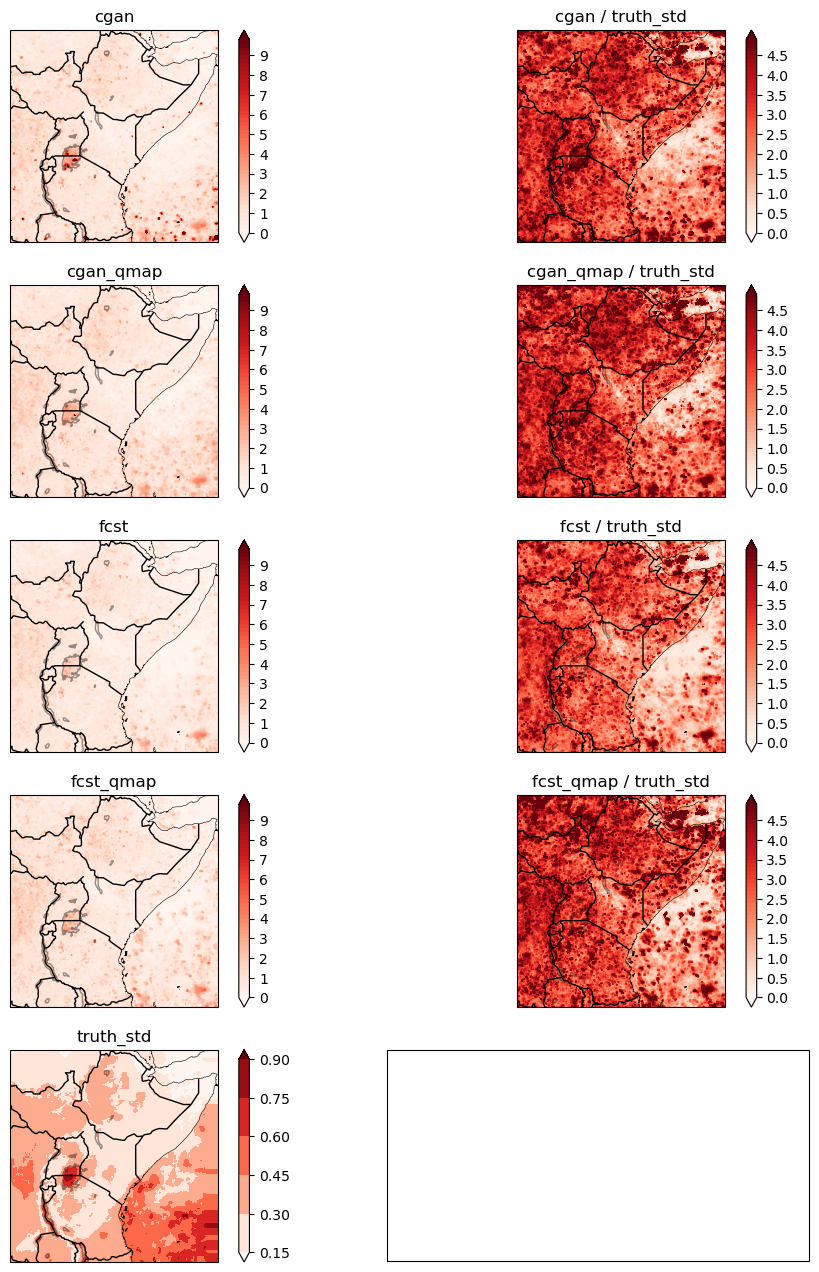

In [ ]:
# RMSE
rmse_dict = {'cgan': np.sqrt(np.mean(np.square(truth_array - samples_gen_array[:,:,:,0]), axis=0)),
            'cgan_qmap' : np.sqrt(np.mean(np.square(truth_array - cgan_corrected[:n_samples,:,:,0]), axis=0)),
            'fcst' : np.sqrt(np.mean(np.square(truth_array - fcst_array), axis=0)),
            'fcst_qmap' : np.sqrt(np.mean(np.square(truth_array - fcst_corrected[:n_samples,:,:]), axis=0))}

# RMSE
fig, ax = plt.subplots(len(rmse_dict.keys())+1,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

value_range_2 = list(np.arange(0, 5, 5 / 50))

for n, (k, v) in enumerate(rmse_dict.items()):
    
    im = plot_contourf(ax[n,0], v, title=k, value_range=value_range, lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im, ax=ax[n,0])
    ax[n,0].set_title(k)
    im2 = plot_contourf(ax[n,1], v / hourly_historical_std, title=k + ' / truth_std', value_range=value_range_2 , lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im2, ax=ax[n,1])

im = plot_contourf(ax[n+1,0], hourly_historical_std, title='truth_std', lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+1,0])

# plt.savefig(f'cgan_metrics/rmse_{model_type}_{model_number}.pdf', format='pdf')


In [ ]:

# edge_len =5
# rainy_pixels =truth_array[:,edge_len:-edge_len, edge_len:-edge_len] > 1
# bias_dict = {'cGAN': np.mean(cgan_corrected[:,edge_len:-edge_len, edge_len:-edge_len,0][rainy_pixels] - truth_array[:,edge_len:-edge_len, edge_len:-edge_len][rainy_pixels], axis=0),
#             'IFS' : np.mean(fcst_corrected[:,edge_len:-edge_len, edge_len:-edge_len][rainy_pixels] - truth_array[:,edge_len:-edge_len, edge_len:-edge_len][rainy_pixels], axis=0)}


/tmp/ipykernel_30330/2198329699.py:14: RuntimeWarning: Mean of empty slice
  bias_dict[k] = np.nanmean(bias, axis=0)


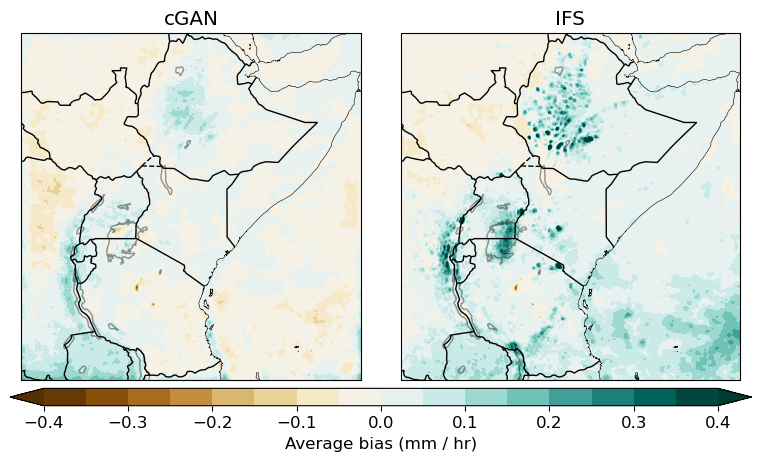

In [38]:
lat_range=np.arange(-10.05, 10.05, 0.1)
lon_range=np.arange(25.05, 45.05, 0.1)
plt.rcParams.update({'font.size': 12})

num_rows = 1
num_cols =2

fig = plt.figure(constrained_layout=True, figsize=(1.5*2.5*num_cols, 1.5*3*num_rows))
gs = gridspec.GridSpec(num_rows + 1, num_cols, figure=fig, 
                       height_ratios=[1]*(num_rows) + [0.05],
                       wspace=0.005)   
bias_dict = {'cGAN': np.mean(cgan_corrected[...,0] - truth_array, axis=0),
            'IFS' : np.mean(fcst_corrected - truth_array, axis=0)}
val_range = list(np.arange(-0.4, 0.45, 0.05))

max_bias_val = max([v.max() for v in bias_dict.values()])

for col, (k,v) in enumerate(bias_dict.items()):

    ax = fig.add_subplot(gs[0, col], projection = ccrs.PlateCarree())

    # value_range = list(np.arange(-0.5, 0.5, 0.01))
    value_range = None

    #remove edges
    edge_len =5
    im = plot_contourf(v, 
                       title=k, 
                       ax=ax,
                       cmap='BrBG', 
                       value_range=val_range, 
                       lat_range=latitude_range,
                       lon_range=longitude_range
                    #    lat_range=latitude_range[edge_len:-edge_len], 
                    #    lon_range=longitude_range[edge_len:-edge_len]
                       )
cbar_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                  )

cb.ax.set_xlabel("Average bias (mm / hr)", loc='center')
plt.savefig(os.path.join(plot_dir, f'bias_{model_type}{model_number}.pdf'), format='pdf', bbox_inches='tight')

In [39]:
os.path.join(plot_dir, f'bias_{model_type}{model_number}.pdf')

'/user/home/uz22147/repos/downscaling-cgan/plots/n4000_202010-202109_45682_e20/bias_final-nologs217600.pdf'

/tmp/ipykernel_30330/3256783353.py:14: RuntimeWarning: Mean of empty slice
  bias_dict[k] = np.nanmean(bias, axis=0)


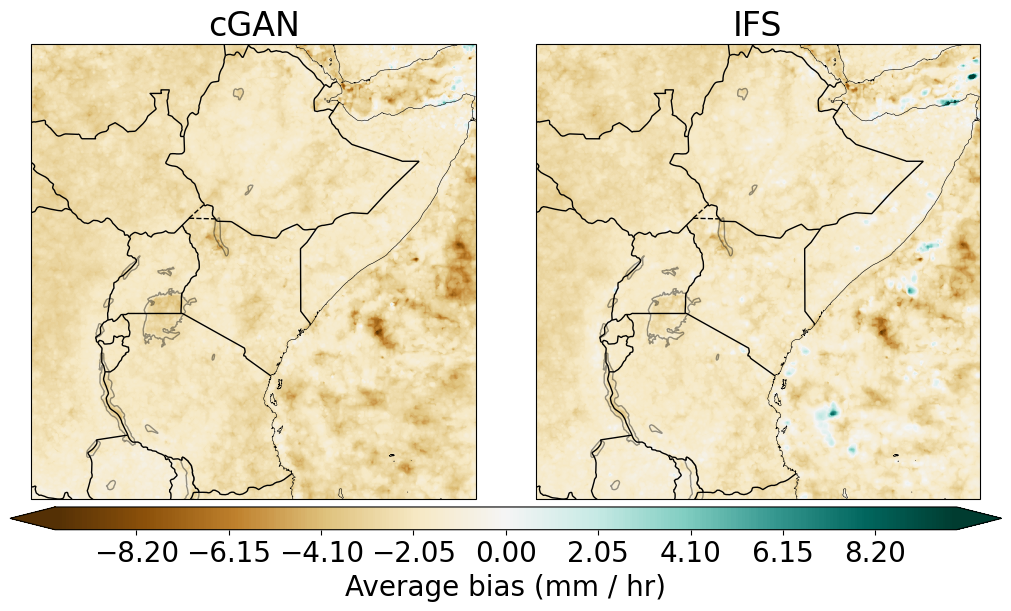

In [ ]:
# bias
data_dict = {'cGAN': cgan_corrected[...,0] ,
            'IFS' : fcst_corrected
            }
plt.rcParams.update({'font.size': 20})
# tmp_truth_array = truth_array[:,edge_len:-edge_len, edge_len:-edge_len]
bias_dict = {}
dry_pixels = truth_array<1

for k, v in data_dict.items():
    bias = v - truth_array
    bias[dry_pixels] = np.nan
    
    bias_dict[k] = np.nanmean(bias, axis=0)
    
lat_range=np.arange(-10.05, 10.05, 0.1)
lon_range=np.arange(25.05, 45.05, 0.1)

num_rows = 1
num_cols =2

fig = plt.figure(constrained_layout=True, figsize=(2*2.5*num_cols, 2*3*num_rows))
gs = gridspec.GridSpec(num_rows + 1, num_cols, figure=fig, 
                       height_ratios=[1]*(num_rows) + [0.05],
                       wspace=0.005)   
# fig, ax = plt.subplots(1,2, 
#                        subplot_kw={'projection' : ccrs.PlateCarree()},
#                        figsize=(16,8))
val_range = list(np.arange(-10, 10.05, 0.05))

max_bias_val = max([v.max() for v in bias_dict.values()])

for col, (k,v) in enumerate(bias_dict.items()):

    ax = fig.add_subplot(gs[0, col], projection = ccrs.PlateCarree())

    # value_range = list(np.arange(-0.5, 0.5, 0.01))
    value_range = None

    #remove edges
    edge_len =5
    im = plot_contourf(v, 
                       title=k, 
                       ax=ax,
                       cmap='BrBG', 
                       value_range=val_range, 
                       lat_range=latitude_range,
                       lon_range=longitude_range
                    #    lat_range=latitude_range[edge_len:-edge_len], 
                    #    lon_range=longitude_range[edge_len:-edge_len]
                       )
cbar_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                  )

cb.ax.set_xlabel("Average bias (mm / hr)", loc='center')
plt.savefig(os.path.join(plot_dir, f'bias_rainy_pixels_{model_type}{model_number}.jpeg'), format='jpeg', bbox_inches='tight')

## CRPS

In [ ]:
from properscoring import crps_ensemble

# crps_ensemble expects truth dims [N, H, W], pred dims [N, H, W, C]
crps_score_grid = crps_ensemble(truth_array, samples_gen_array)
crps_score = crps_score_grid.mean()

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(5,5))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

im = ax.contourf(longitude_range, latitude_range, np.mean(crps_score_grid, axis=0), transform=ccrs.PlateCarree(),
                    cmap='Reds', 
                    # levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')

ax.coastlines(resolution='10m', color='black', linewidth=0.4)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(im, ax=ax)
plt.savefig(f'cgan_metrics/crps_{model_type}_{model_number}.pdf', format='pdf')


## Scatter plots

In [ ]:
import random

truth = arrays['truth']
samples_gen = arrays['samples_gen']

(num_images, height, width, ensemble_size) = samples_gen.shape

stacked_truth = np.repeat(truth[:, :, :, np.newaxis], ensemble_size, axis=3)

In [ ]:
indexes = random.sample(range(len(samples_gen.flatten())), 10000)

In [ ]:
plt.scatter(samples_gen.flatten()[indexes], stacked_truth.flatten()[indexes])

# Fractional skill score

In [ ]:
#evaluate percentage of rainy pixels based on threshold
daily_thresholds = range(1,40)
num_rainy_pixels = []
for thr in daily_thresholds:
    num_rainy_pixels.append((truth_array >= thr/24.0).astype(np.single).mean())
plt.plot(daily_thresholds, num_rainy_pixels)

KeyboardInterrupt: 

In [ ]:
from dsrnngan.evaluation.evaluation import get_fss_scores

window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200, 270]
scales = [2*w+1 for w in window_sizes]
n_samples = 4000
fss_data_dict = {
                    'cGAN': cgan_corrected[:n_samples, :, :, 0],
                    'IFS': fcst_corrected[:n_samples, :, :]}

# get quantiles
# quantile_locs = [0.5, 0.985, 0.999, 0.9999]
# hourly_thresholds = np.quantile(truth_array, quantile_locs)
hourly_thresholds = [15]
fss_results = get_fss_scores(truth_array, fss_data_dict, hourly_thresholds, scales, n_samples)

# # # Save results 
# with open(f'fss_{model_type}_{model_number}.pkl', 'wb+') as ofh:
#     pickle.dump(fss_results, ofh)

  0%|          | 0/2 [01:54<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Save results 
with open(f'fss_{model_type}_{model_number}.pkl', 'wb+') as ofh:
    pickle.dump(fss_results, ofh)

In [9]:
with open(os.path.join(plot_dir, 'fss_cl100-medium-nologs_217600.pkl'), 'rb') as ifh:
    fss_results = pickle.load(ifh)

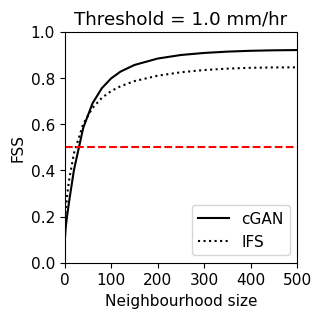

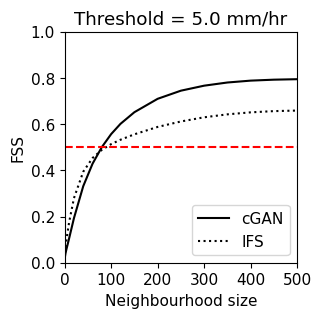

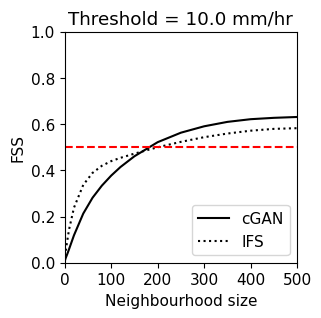

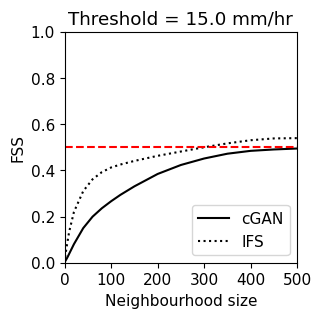

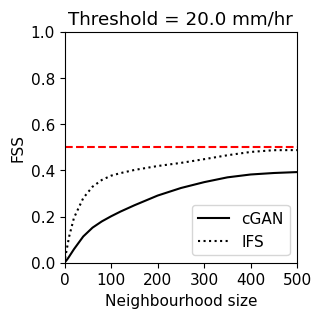

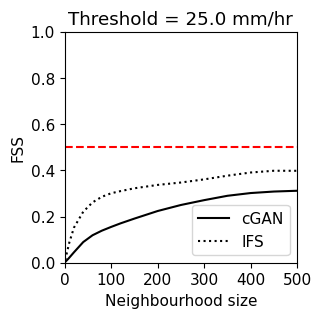

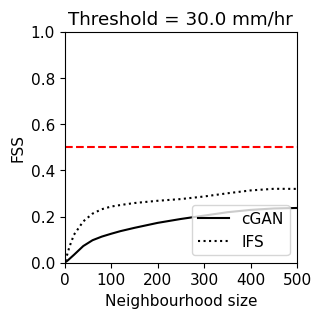

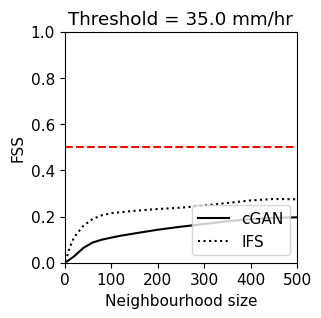

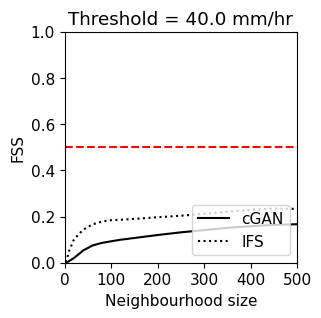

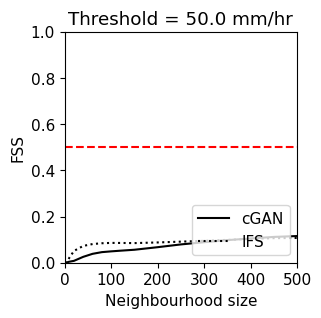

In [12]:
plt.rcParams.update({'font.size': 11})
# fig.tight_layout(pad=4.0)

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10))]
n=0
thr=fss_results['thresholds'][0]
for n, thr in enumerate(fss_results['thresholds']):
    fig, ax = plt.subplots(1, 1, figsize = (3,3))
    
    
    for m, (name, scores) in enumerate(fss_results['scores'].items()):
        label = 'cGAN' if name == 'cgan' else 'IFS'
        ax.plot(fss_results['window_sizes'], scores[n], label=label, color='k', linestyle=linestyles[m])
        

    ax.set_title(f'Threshold = {thr:0.1f} mm/hr')

    ax.hlines(0.5, 0, max(fss_results['window_sizes']), linestyles='dashed', colors=['r'])
    ax.set_ylim(0,1)
    ax.set_xlabel('Neighbourhood size')
    ax.set_ylabel('FSS')
    ax.set_xlim(0, max(fss_results['window_sizes']))
    # if thr == 1.0:
    ax.legend(loc='lower right')
    # else:
        # ax.legend(loc='upper left')
        
    plt.savefig(os.path.join(plot_dir, f'fss_thr{thr}_{model_type}_{model_number}.pdf'), format='pdf', bbox_inches='tight')

In [ ]:
# FSS for regions
window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200]
n_samples = 10


# get quantiles
quantile_locs = [0.5, 0.985, 0.999, 0.9999]
fss_area_results = {}
for n, (area, area_range) in enumerate(special_areas.items()):
    
    lat_range_ends = area_range['lat_range']
    lon_range_ends = area_range['lon_range']
    lat_range_index = area_range['lat_index_range']
    lon_range_index = area_range['lon_index_range']
    lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.0001, 0.1)
    lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.0001, 0.1)
    
    area_truth_array = truth_array[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]
    fss_data_dict = {
                    'cgan': samples_gen_array[:n_samples, lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1], 0],
                    'ifs': fcst_array[:n_samples,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]],
                    'fcst_qmap': fcst_corrected[:n_samples, lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]}  
    fss_area_results[area] = get_fss_scores(area_truth_array, fss_data_dict, quantile_locs, window_sizes, n_samples)
    
    plot_fss_scores(fss_results=fss_area_results[area], output_folder='plots', output_suffix=f'{area}_{model_type}_{model_number}')
    

### FSS at grid cells

In [ ]:
from dsrnngan.evaluation.scoring import get_metric_by_hour, get_metric_by_grid_cell, fss

threshold = 5
neighbourhood_size = 100
bin_width=3
area = 'All'
area_range = special_areas[area]
lat_range_ends = area_range['lat_range']
lon_range_ends = area_range['lon_range']
lat_range_index = [area_range['lat_index_range'][0], area_range['lat_index_range'][-1] +1]
lon_range_index = [area_range['lon_index_range'][0], area_range['lon_index_range'][-1] +1]
lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.001, 0.1)
lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.001, 0.1)

area_truth_array = truth_array[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]

fss_fn = lambda y_true, y_pred : fss(obs_array=np.expand_dims(np.expand_dims(y_true, axis=0), axis=-1), fcst_array=np.expand_dims(np.expand_dims(y_pred, axis=0), axis=-1), scale=neighbourhood_size, thr=threshold)
metric_fn = lambda y_true, y_pred: get_metric_by_grid_cell(metric_fn=fss_fn, y_true=y_true, y_pred=y_pred)
fcst_fss_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn=metric_fn, obs_array=truth_array[:,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1], 
                                                      fcst_array=fcst_corrected[:,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1], hours=hours, bin_width=bin_width)
gan_fss_by_hour, _ = get_metric_by_hour(metric_fn=metric_fn, obs_array=truth_array[:,lat_range_index[0]:lat_range_index[-1]+1, 
                                                                                   lon_range_index[0]:lon_range_index[-1]+1], 
                                        fcst_array=cgan_corrected[:,lat_range_index[0]:lat_range_index[-1]+1, lon_range_index[0]:lon_range_index[-1]+1,0], hours=hours, bin_width=bin_width)

Text(0.5, 0, 'FSS(GAN) - FSS(IFS)')

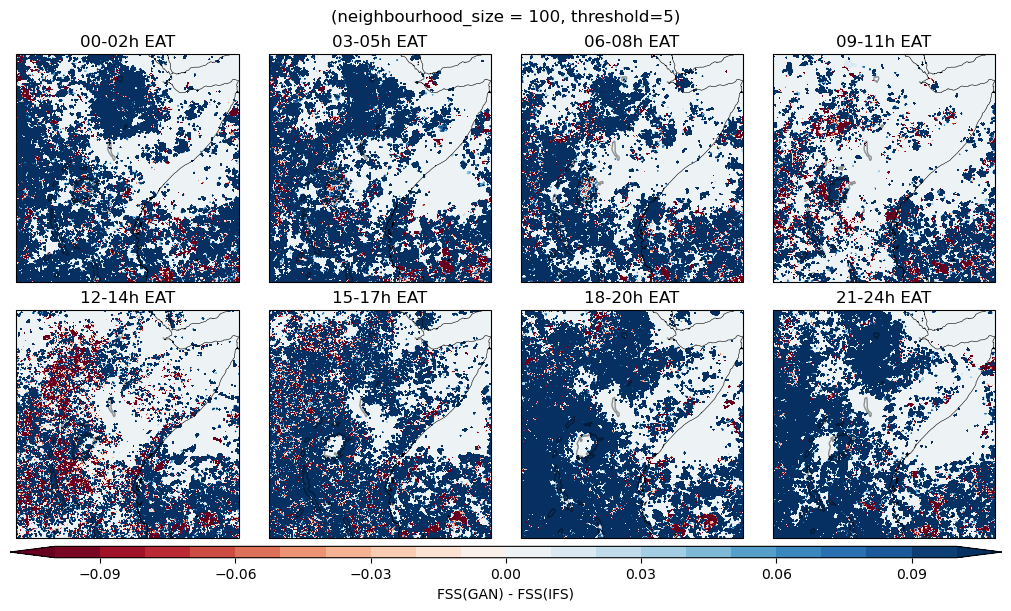

In [ ]:
from dsrnngan.evaluation.plots import plot_contourf
from scipy.ndimage import uniform_filter
n_rows = 2
n_cols = int(np.ceil(len(fcst_fss_by_hour)/n_rows))

fig = plt.figure(constrained_layout=True, figsize=(2.5*n_cols, 3*n_rows))
gs = gridspec.GridSpec(n_rows + 1, n_cols, figure=fig, 
                    width_ratios=[1]*(n_cols ),
                    height_ratios=[1]*(n_rows) + [0.05],
                wspace=0.005)  
    
digitized_hours = np.digitize(hours, bins=hour_bin_edges)

for n, hour_ix in enumerate(fcst_fss_by_hour):
    row = int(n / n_cols)
    column = n % n_cols
    ax = fig.add_subplot(gs[row, column], projection = ccrs.PlateCarree())

    hour_indexes = np.where(np.array(digitized_hours) == hour_ix)[0]

    if n == len(hour_bin_edges)-1:
        hr_end = 24
    else:
        hr_end = hour_bin_edges[n+1]-1
    bias = gan_fss_by_hour[hour_ix] -fcst_fss_by_hour[hour_ix]
    smoothed_bias = uniform_filter(np.nan_to_num(bias,0), size=21, mode='reflect')
    
    im = plot_contourf(bias, f"{hour_bin_edges[n]:02d}-{hr_end:02d}h EAT", ax, value_range=np.arange(-0.1,0.11,0.01), 
                lon_range=lon_range, 
                lat_range=lat_range,
                    cmap='RdBu', extend='both', add_borders=False)


fig.suptitle(f'(neighbourhood_size = {neighbourhood_size}, threshold={threshold})')
cbar_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                )
cb.ax.set_xlabel(f"FSS(GAN) - FSS(IFS)", 
                 loc='center')
# plt.savefig(f'plots/fss_by_hour_thr{threshold}_{area}_{model_type}_{model_number}.pdf', format='pdf')

In [ ]:
from dsrnngan.evaluation.scoring import get_filtered_array


data_dict = {'imerg' : truth_array, 'cgan': samples_gen_array[:, :, :, 0], 'ifs': fcst_array
             }
mode = 'constant'

for thr_index in range(len(hourly_thresholds)):

    thr = hourly_thresholds[thr_index] # 0 = median

    arrays_filtered = {}

    for size in window_sizes:

        arrays_filtered[size] = {}

        for k, d in tqdm(data_dict.items()):  
            arrays_filtered[size][k] = []
            for n in range(truth_array.shape[0]):
                # Convert to binary fields with the given intensity threshold
                I = (d >= thr).astype(np.single)

                # Compute fractions of pixels above the threshold within a square
                # neighboring area by applying a 2D moving average to the binary fields        
                arrays_filtered[size][k].append(get_filtered_array(int_array=I, mode=mode, size=size))

        for k in arrays_filtered[size]:
            arrays_filtered[size][k] = np.stack(arrays_filtered[size][k])

with open(f'fss_grid_{model_type}_{model_number}_thr{thr_index}.pkl', 'wb+') as ofh:
    pickle.dump(arrays_filtered, ofh)    


NameError: name 'hourly_thresholds' is not defined

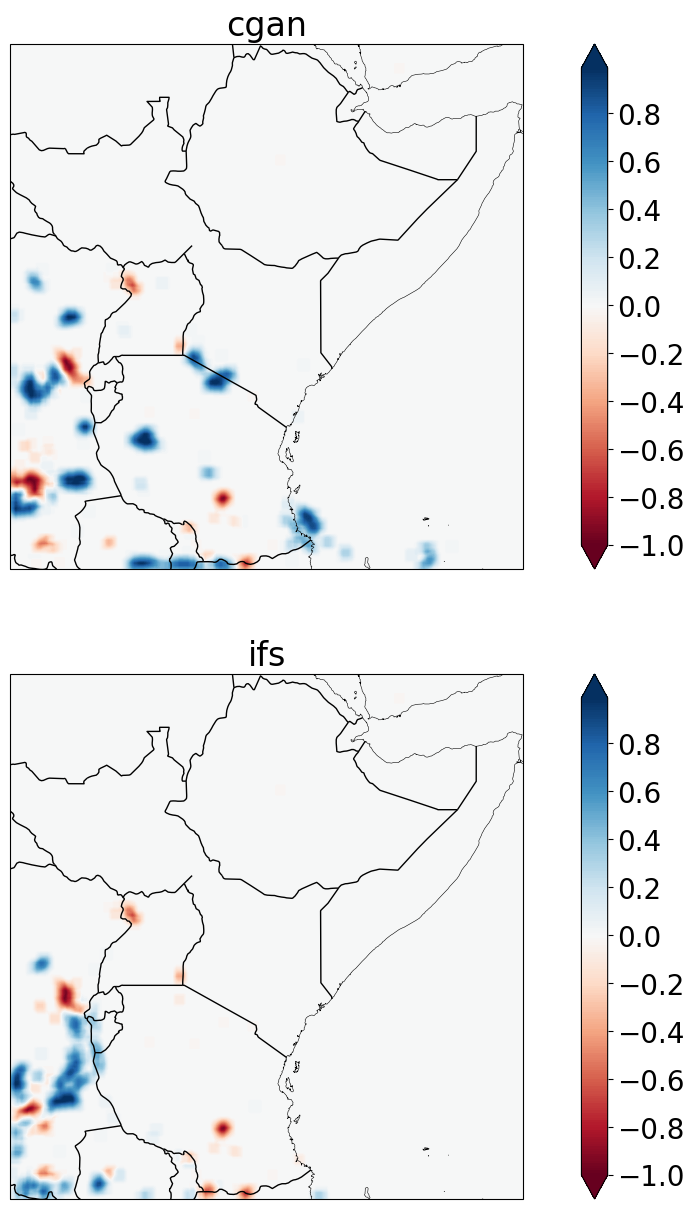

In [ ]:
# plot MSE of fractions
n = 5
size = window_sizes[n]
bias = {}
for k in data_dict:
    
    if k == 'imerg':
        pass
    
    else:
        arr = arrays_filtered[size][k]
        bias[k] = np.mean(arr - arrays_filtered[size]['imerg'], axis=0)

fig, ax = plt.subplots(len(bias), 1, figsize=(15,15), subplot_kw={'projection' : ccrs.PlateCarree()})

for n, (k, v) in enumerate(bias.items()):
    im = plot_contourf(ax[n], v, title=k, lat_range=latitude_range, value_range=np.arange(-1, 1, 0.01), lon_range=longitude_range,cmap='RdBu')
    plt.colorbar(im, ax=ax[n])

## Diurnal cycle

In [17]:
from dsrnngan.evaluation.evaluation import get_diurnal_cycle
from dsrnngan.evaluation.scoring import get_metric_by_hour

num_diurnal_cycles = 4000
diurnal_data_dict = {'Obs (IMERG)': truth_array[:num_diurnal_cycles,...],
                         'cGAN': cgan_corrected[:num_diurnal_cycles,:,:,:20],
                         'IFS': fcst_corrected[:num_diurnal_cycles,...]
                         }
ensemble_size = diurnal_data_dict['cGAN'].shape[-1]
metric_fn = lambda x,y: x.mean()

cgan_metrics_by_hour = []
for n in tqdm(range(ensemble_size)):
    metric_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn, 
                                                        obs_array=diurnal_data_dict['cGAN'][...,n], 
                                                        fcst_array=diurnal_data_dict['cGAN'][...,n], 
                                                        hours=hours[:num_diurnal_cycles], 
                                                        bin_width=3)
    cgan_metrics_by_hour.append(metric_by_hour)

100%|██████████| 20/20 [04:51<00:00, 14.57s/it]


In [1]:
cgan_metric_mean = np.mean(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)
cgan_metric_std = np.std(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)
cgan_metric_max = np.max(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)
cgan_metric_min = np.min(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)

NameError: name 'np' is not defined

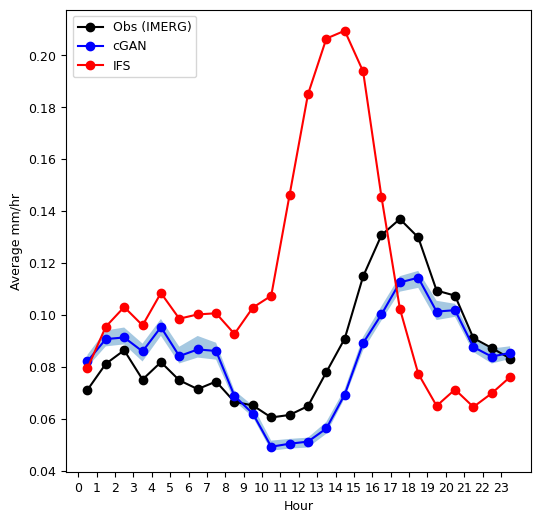

In [184]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
format_lkp = {'cGAN': {'color': 'b'}, 'IFS': {'color': 'r'}, 'Obs (IMERG)': {}}

for name, arr in diurnal_data_dict.items():
    if name == 'cGAN':
        ax.plot(metric_by_hour.keys(),cgan_metric_mean, '-o', label=name, color=format_lkp[name].get('color', 'black'))

        ax.fill_between(metric_by_hour.keys(), cgan_metric_min, cgan_metric_max, alpha=0.4)
    else:
        metric_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn, obs_array=arr, fcst_array=arr, hours=hours[:num_diurnal_cycles], bin_width=3)
        ax.plot(metric_by_hour.keys(), metric_by_hour.values(), '-o', label=name, color=format_lkp[name].get('color', 'black'))

ax.set_xticks(np.array(list(metric_by_hour.keys())) - .5)
ax.set_xticklabels(hour_bin_edges)
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')
# ax.set_ylim([0, 0.25])
ax.legend(loc='upper left')

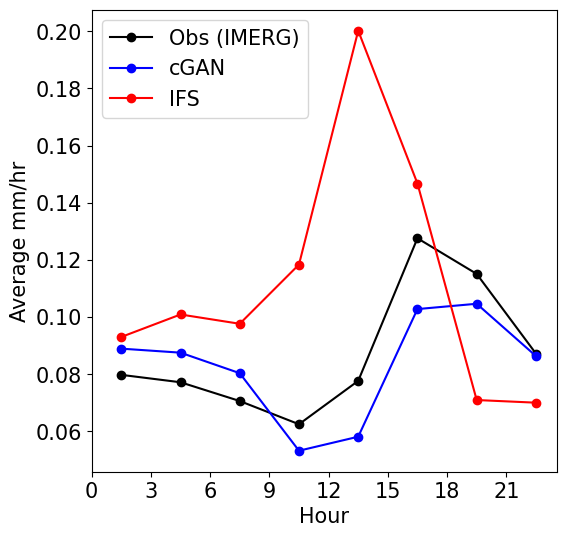

In [ ]:
from dsrnngan.evaluation.evaluation import get_diurnal_cycle
from dsrnngan.evaluation.scoring import get_metric_by_hour

diurnal_data_dict = {'Obs (IMERG)': truth_array,
                         'cGAN': cgan_corrected[:,:,:,0],
                         'IFS': fcst_corrected
                         }
format_lkp = {'cGAN': {'color': 'b'}, 'IFS': {'color': 'r'}, 'Obs (IMERG)': {}}
metric_types = {'quantile_999': lambda x,y: np.quantile(x, 0.999),
                'quantile_9999': lambda x,y: np.quantile(x, 0.9999),
                'quantile_99999': lambda x,y: np.quantile(x, 0.99999),
               'median': lambda x,y: np.quantile(x, 0.5),
               'mean': lambda x,y: np.mean(x)}
metric_name = 'mean'
metric_fn = metric_types[metric_name]

plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,1, figsize=(6,6))
for name, arr in diurnal_data_dict.items():
    if name == 'cGAN':
        cgan_metrics_by_hour = []
        for n in tqdm(range(ensemble_size)):
            metric_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn, 
                                                                obs_array=diurnal_data_dict['cGAN'][...,n], 
                                                                fcst_array=diurnal_data_dict['cGAN'][...,n], 
                                                                hours=hours[:num_diurnal_cycles], 
                                                                bin_width=3)
            cgan_metrics_by_hour.append(metric_by_hour)
        cgan_metric_mean = np.mean(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)
        cgan_metric_std = np.std(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)
        cgan_metric_max = np.max(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)
        cgan_metric_min = np.min(np.stack([list(item.values()) for item in cgan_metrics_by_hour]), axis=0)
    
        ax.plot(metric_by_hour.keys(),cgan_metric_mean, '-o', label=name, color=format_lkp[name].get('color', 'black'))
        ax.fill_between(metric_by_hour.keys(), cgan_metric_min, cgan_metric_max, alpha=0.4)
    else:
        metric_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn, obs_array=arr, fcst_array=arr, hours=hours, bin_width=3)
        ax.plot(metric_by_hour.keys(), metric_by_hour.values(), '-o', label=name, color=format_lkp[name].get('color', 'black'))
    

ax.set_xticks(np.array(list(metric_by_hour.keys())) - .5)
ax.set_xticklabels(hour_bin_edges)
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')
# ax.set_ylim([0, 0.25])
ax.legend(loc='upper left')

plt.savefig(os.path.join(plot_dir,f'diurnal_cycle_{metric_name}_{model_type}_{model_number}.pdf'), bbox_inches='tight')

In [40]:
from dsrnngan.evaluation.evaluation import get_diurnal_cycle
from dsrnngan.evaluation.scoring import get_metric_by_hour
plt.rcParams.update({'font.size': 17})

special_areas = {'All': {'lat_range': [min(latitude_range), max(latitude_range)], 'lon_range': [min(longitude_range), max(longitude_range)], 'abbrv': 'ALL'},
                 'Lake Victoria': {'lat_range': [-3.05,0.95], 'lon_range': [31.55, 34.55], 'abbrv': 'LV'},
                 'Somalia': {'lat_range': [-1.05,4.05], 'lon_range': [40.0, 44.05],  'abbrv': 'S'},
                 'S Sudan / S Ethiopia': {'lat_range': [4.35, 6.90], 'lon_range': [33.65, 36.9],  'abbrv': 'SSE'},
                 'Coast': {'lat_range': [-11.05, -4.70 ], 'lon_range': [38.0,39.0],  'abbrv': 'C'},
                 'West LV Basin': {'lat_range': [-4.70,0.30], 'lon_range': [29.5,31.3],  'abbrv': 'WLVB'},
                 'East LV Basin': {'lat_range': [-3.15, 1.55], 'lon_range': [34.5,36.0],  'abbrv': 'ELVB'},
           'NW Ethiopian Highlands': {'lat_range': [6.10, 14.15], 'lon_range': [34.60, 40.30], 'abbrv': 'NWEH'}

}


for k, v in special_areas.items():
    lat_vals = [lt for lt in lat_range_list if v['lat_range'][0] <= lt <= v['lat_range'][1]]
    lon_vals = [ln for ln in lon_range_list if v['lon_range'][0] <= ln <= v['lon_range'][1]]
    
    if lat_vals and lon_vals:
 
        special_areas[k]['lat_index_range'] = [lat_range_list.index(lat_vals[0]), lat_range_list.index(lat_vals[-1])]
        special_areas[k]['lon_index_range'] = [lon_range_list.index(lon_vals[0]), lon_range_list.index(lon_vals[-1])]
        
area = 'All'
area_range = special_areas[area]
lat_range_ends = area_range['lat_range']
lon_range_ends = area_range['lon_range']
lat_range_index = [area_range['lat_index_range'][0], area_range['lat_index_range'][-1] +1]
lon_range_index = [area_range['lon_index_range'][0], area_range['lon_index_range'][-1] +1]
lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.001, 0.1)
lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.001, 0.1)


In [ ]:


diurnal_data_dict = {'IMERG': truth_array[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]],
                    'cGAN': cgan_corrected[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1], 0],
                    'IFS': fcst_corrected[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]
                    }

color_lookup = {'cGAN': 'b', 'IMERG': 'k', 'IFS': 'r'}
metric_types = {'quantile_999': {'metric': lambda x,y: np.quantile(x, 0.999), 'name': '99.9th percentile'},
                'quantile_9999': {'metric': lambda x,y: np.quantile(x, 0.9999), 'name': '99.99th percentile'},
                'quantile_99999': {'metric': lambda x,y: np.quantile(x, 0.99999), 'name': '99.999th percentile'},
               'median': {'metric': lambda x,y: np.quantile(x, 0.5), 'name': 'Median'},
               'mean': {'metric': lambda x,y: np.mean(x), 'name': 'Mean'}}

for metric_name in metric_types:
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    for name, arr in tqdm(diurnal_data_dict.items()):

        metric_fn = metric_types[metric_name]['metric']
        metric_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn, obs_array=arr, fcst_array=arr, hours=hours, bin_width=3)

        mean_vals = np.array(list(metric_by_hour.values()))
        ax.plot(np.array(list(metric_by_hour.keys())), mean_vals, '-o', label=name, color=color_lookup[name])


    ax.set_xticks(np.array(list(metric_by_hour.keys())) - .5)
    ax.set_xticklabels(hour_bin_edges)
    ax.set_xlabel('Hour (EAT)')
    ax.set_ylabel(f"{metric_types[metric_name]['name']} (mm/hr)")
    # ax.set_ylim(6,10)
    ax.legend(loc='upper right')

    # ## Diurnal cycle
    # diurnal_data_sums = {}
    # for k, d in smoothed_diurnal_data_dict.items():
        
    #     diurnal_data_sums[k], hourly_counts = get_diurnal_cycle(d, dates, hours, longitude_range, latitude_range)
        
        

    # fig, ax = plt.subplots(1,1, figsize=(5,5))

    # for name, data in diurnal_data_sums.items():
        
    #     mean_hourly_data = [(data[n]/hourly_counts[n]) for n in range(24)]
    #     # std_dev_hourly_data = np.array([data[n].std() for n in range(24)])
        
    #     # ax.errorbar(x=range(24), y=mean_hourly_data, fmt='-o', yerr=2*std_dev_hourly_data, label=name)
    #     ax.plot(mean_hourly_data, '-o', label=name)
        
    # ax.legend()
    # ax.set_xlabel('Hour')
    # ax.set_ylabel('Average mm/hr')
    plt.savefig(os.path.join(plot_dir, f"diurnal_cycle_{area.replace(' ', '_')}_{metric_name}_{model_type}_{model_number}.pdf"), format='pdf', bbox_inches='tight')

In [ ]:
cgan_corrected = samples_gen_array.copy()
fcst_corrected = fcst_array.copy()

In [ ]:
# Diurnal cycles for different areas
hourly_area_sums, hourly_area_counts = {}, {}

diurnal_data_dict = {'Obs (IMERG)': truth_array,
                    'GAN': samples_gen_array[..., 0],
                    'IFS': fcst_corrected
                    }


for n, (area, area_range) in enumerate(special_areas.items()):
    
    hourly_area_sums[area] = {}
    hourly_area_counts[area] = {}
    
    lat_range_ends = area_range['lat_range']
    lon_range_ends = area_range['lon_range']
    lat_range_index = area_range['lat_index_range']
    lon_range_index = area_range['lon_index_range']
    lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.0001, 0.1)
    lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.0001, 0.1)
    
    for name, d in diurnal_data_dict.items():
        hourly_area_sums[area][name], hourly_area_counts[area][name] = get_diurnal_cycle( d[:, lat_range_index[0]:lat_range_index[1]+1, lon_range_index[0]:lon_range_index[1]+1], 
                                                                                    dates, hours, 
                                                                                    longitude_range=lon_range, 
                                                                                    latitude_range=lat_range)

# Plot diurnal cycle for the different areas
fig, ax = plt.subplots(len(special_areas),1, figsize=(12,18))
fig.tight_layout(pad=3)

# TODO: get errorbars on this
for n, (area, d) in enumerate(hourly_area_sums.items()):
    for name, arr in d.items():
        mean_hourly_data = [np.mean(arr[n] / hourly_area_counts[area][name][n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, '-o', label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(area)

In [ ]:
# Diurnal cycle for different seasons

from collections import Counter

seasons_dict = {'MAM': [3,4,5], 'OND': [10,11,12]}
hourly_season_data_obs, hourly_season_data_sample, hourly_season_data_fcst, hourly_season_counts = {}, {}, {}, {}

for n, (season, month_range) in enumerate(seasons_dict.items()):
    hourly_season_data_obs[season], hourly_season_data_sample[season], hourly_season_data_fcst[season], hourly_season_counts[season] = get_diurnal_cycle( truth_array, 
                                                                                             samples_gen_array, 
                                                                                             fcst_array, training_dates, training_hours, 
                                                                                             longitude_range=lon_range, latitude_range=lat_range)

# Plot diurnal cycle for the different areas

fig, ax = plt.subplots(len(seasons_dict),1, figsize=(12,12))
fig.tight_layout(pad=3)
smoothed_diurnal_data_dict = {'IMERG': hourly_season_data_obs,
                     'cGAN sample': hourly_season_data_sample,
                     'IFS': hourly_season_data_fcst}

for n, season in enumerate(seasons_dict):
    for name, data in smoothed_diurnal_data_dict.items():
        
        mean_hourly_data = [np.mean(data[season][n] / hourly_season_counts[season][n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, '-o',label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(season)

In [ ]:
cgan_corrected = samples_gen_array.copy()
fcst_corrected = fcst_array.copy()

In [ ]:
# function to locate peak rainfall

def get_peak_rainfall_hour_bin(array, hours, bin_width=1):
    metric_fn = lambda x,y: np.mean(x)

    metric_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn, array, array, hours, bin_width=bin_width)
    max_time_bin = np.argmax(np.array(list(metric_by_hour.values())))
    
    return max_time_bin


In [ ]:
# box and whisker plot
from scipy.ndimage import uniform_filter
from dsrnngan.evaluation.evaluation import get_diurnal_cycle
from dsrnngan.evaluation.scoring import get_metric_by_hour

bin_width = 3
metric_fn_ident = lambda x, y: x
truth_array_by_hour, _ = get_metric_by_hour(metric_fn_ident, obs_array=truth_array, fcst_array=truth_array, hours=hours, bin_width=bin_width)
fcst_array_by_hour, _ = get_metric_by_hour(metric_fn_ident, obs_array=fcst_corrected, fcst_array=fcst_corrected, hours=hours, bin_width=bin_width)
cgan_array_by_hour, _ = get_metric_by_hour(metric_fn_ident, obs_array=cgan_corrected[...,0], fcst_array=cgan_corrected[...,0], hours=hours, bin_width=bin_width)

# threshold=np.quantile(truth_array, 0.99)
# threshold=5
# truth_array_by_hour = {k: v[v>threshold] for k, v in truth_array_by_hour.items()}
# fcst_array_by_hour = {k: v[v>threshold] for k, v in fcst_array_by_hour.items()}
# cgan_array_by_hour = {k: v[v>threshold] for k, v in cgan_array_by_hour.items()}


In [ ]:
truth_means_by_hour = {k: v.mean() for k, v in truth_array_by_hour.items()}
fcst_means_by_hour = {k: v.mean() for k, v in fcst_array_by_hour.items()}
cgan_means_by_hour = {k: v.mean() for k, v in cgan_array_by_hour.items()}

In [ ]:
plt.plot(truth_means_by_hour.values())
plt.plot(fcst_means_by_hour.values())
plt.plot(cgan_means_by_hour.values())

NameError: name 'truth_means_by_hour' is not defined

Text(0, 0.5, 'Precipitation (mmm/hr)')

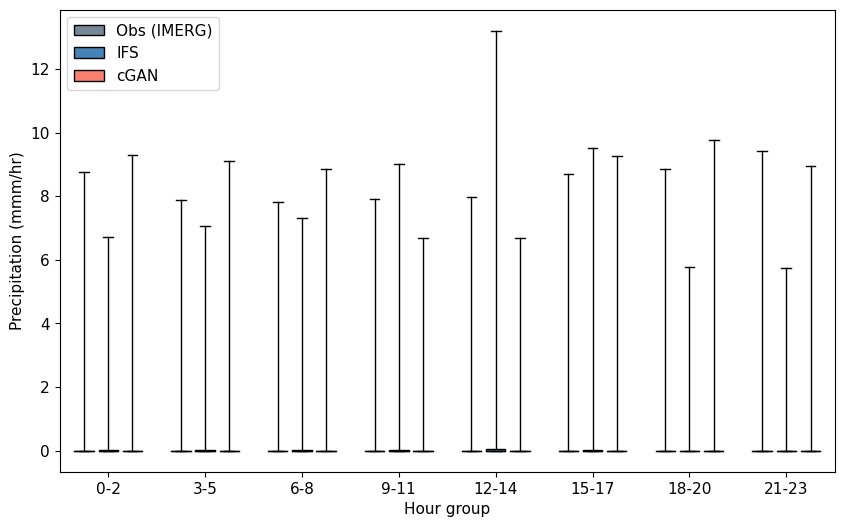

In [ ]:
plt.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(1,1, figsize=(10,6))
central_positions = np.arange(0,2*max(truth_array_by_hour),2)

bplot1 = ax.boxplot([item.flatten() for item in truth_array_by_hour.values()], showfliers=False, positions=central_positions - 0.5, 
                    widths=0.4, patch_artist=True, whis=[5, 99.9])
bplot2 =ax.boxplot([item.flatten() for item in fcst_array_by_hour.values()], showfliers=False, positions=central_positions, 
                   widths=0.4, patch_artist=True, whis=[5, 99.9])
bplot3 =ax.boxplot([item.flatten() for item in cgan_array_by_hour.values()], showfliers=False, positions=central_positions + 0.5, 
                   widths=0.4, patch_artist=True, whis=[5, 99.9])
b_plots = [bplot1, bplot2, bplot3]

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    for n, bp in enumerate(b_plots):
        plt.setp(bp[element], color='black')
        
colors = ['lightslategray', 'steelblue', 'salmon']
for n, bplot in enumerate(b_plots):
    for patch, color in zip(bplot['boxes'], [colors[n]]*len(bplot['boxes'])):
        patch.set_facecolor(color)

ax.legend([bplot1["boxes"][0], bplot2["boxes"][0], bplot3['boxes'][0]], ['Obs (IMERG)', 'IFS', 'cGAN'], loc='upper left')
# ax.set_ylim([0,2.5])
ax.set_xticks(central_positions)
ax.set_xticklabels([f'{bin_width*n}-{bin_width*(n+1)-1}' for n in range(len(central_positions))])

# ax.set_xticklabels(['0-6', '7-12', '13-18', '19-24'])
ax.set_xlabel('Hour group')
ax.set_ylabel('Precipitation (mmm/hr)')

In [76]:
# Diurnal maximum map
import xarray as xr
from datetime import datetime
from dsrnngan.utils.utils import get_local_hour
from scipy.ndimage import uniform_filter, uniform_filter1d
import xarray as xr

area = 'Lake Victoria'
area_range = special_areas[area]
lat_range_ends = area_range['lat_range']
lon_range_ends = area_range['lon_range']
lat_range_index = [area_range['lat_index_range'][0], area_range['lat_index_range'][-1] +1]
lon_range_index = [area_range['lon_index_range'][0], area_range['lon_index_range'][-1] +1]
lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.001, 0.1)
lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.001, 0.1)


hour_bin_edges = np.arange(0, 24, 1)
filter_size = 31 # roughly the size of lake victoria region
digitized_hours = np.digitize(hours, bins=hour_bin_edges)

n_samples = truth_array.shape[0]
raw_diurnal_data_dict = {'Obs (IMERG)': truth_array[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]],
                    'cGAN':cgan_corrected[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1], 0],
                    'IFS': fcst_corrected[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]}

peak_dict = {}

for name in raw_diurnal_data_dict:
    
    da = xr.DataArray(
        data=raw_diurnal_data_dict[name],
        dims=["hour_range", "lat", "lon"],
        coords=dict(
            lon=(lon_range),
            lat=(lat_range),
            hour_range=digitized_hours,
        ),
        attrs=dict(
            description="Precipitation.",
            units="mm/hr",
        ),
    )


    smoothed_vals = uniform_filter1d(da.groupby('hour_range').mean().values, 3, axis=0, mode='wrap')
    peak_dict[name] = np.argmax(smoothed_vals, axis=0)


IMERG 23
cGAN 23
IFS 16


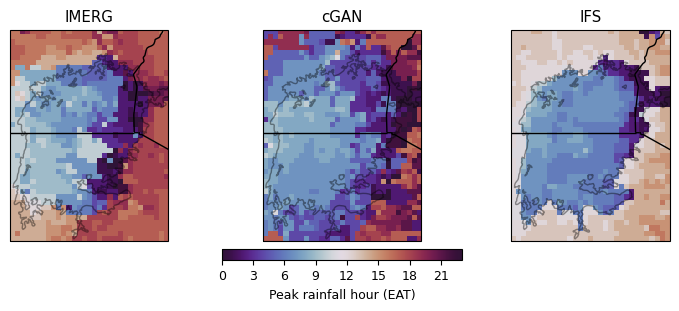

In [78]:

from dsrnngan.evaluation import plots
from matplotlib.pyplot import cm
from matplotlib import colors
plt.rcParams.update({'font.size': 9})

n_cols = len(peak_dict)
n_rows = 1
fig = plt.figure(constrained_layout=True, figsize=(2.5*n_cols, 3*n_rows))
gs = gridspec.GridSpec(n_rows + 1, n_cols, figure=fig, 
                    width_ratios=[1]*(n_cols ),
                    height_ratios=[1]*(n_rows) + [0.05],
                wspace=0.005) 

ax = fig.add_subplot(gs[0, 0], projection = ccrs.PlateCarree())

filter_size=1


n=1
for name, peak_data in peak_dict.items():
    if name != 'Obs (IMERG)':
        ax = fig.add_subplot(gs[0, n], projection = ccrs.PlateCarree())
        smoothed_peak_data = uniform_filter(peak_data.copy(), size=filter_size, mode='reflect')
        
        im1 = ax.imshow(np.flip(smoothed_peak_data, axis=0), extent = [ min(lon_range), max(lon_range), min(lat_range), max(lat_range)], 
                transform=ccrs.PlateCarree(), cmap='twilight_shifted', vmin=0, vmax=23)

        
        n+=1
    else:
        smoothed_peak_data = uniform_filter(peak_data.copy(), size=filter_size, mode='reflect')

        name = 'IMERG'
        im_imerg = ax.imshow(np.flip(smoothed_peak_data, axis=0), extent = [ min(lon_range), max(lon_range), min(lat_range), max(lat_range)], 
                transform=ccrs.PlateCarree(), cmap='twilight_shifted', vmin=0, vmax=23)
    print(name, peak_data.max())
    ax.add_feature(plots.border_feature)
    ax.add_feature(plots.disputed_border_feature)
    ax.add_feature(plots.lake_feature, alpha=0.4)
    ax.coastlines(resolution='10m', color='black', linewidth=0.4)
    ax.set_title(name)
        
cbar_ax = fig.add_subplot(gs[-1, 1])
# cb = fig.colorbar(cm.ScalarMappable(norm=None, cmap=colors.Colormap('twilight_shifted')), cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10, ticks=range(len(hour_bin_edges)))
cb = fig.colorbar(im_imerg, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10, ticks=range(len(hour_bin_edges)),
                    )
cb.ax.set_xticks(range(0,24,3))
cb.ax.set_xticklabels(range(0,24,3))
cb.ax.set_xlabel("Peak rainfall hour (EAT)", loc='center')
plt.savefig(os.path.join(plot_dir, f"diurnal_cycle_map_{area.replace(' ', '_')}_{model_type}_{model_number}.pdf"), format='pdf', bbox_inches='tight')

In [62]:
name

'IFS'

In [ ]:
os.path.join(plot_dir, f'diurnal_cycle_map_{model_type}_{model_number}.pdf')

'/user/home/uz22147/repos/downscaling-cgan/plots/n4000_202010-202109_45682_e20/diurnal_cycle_map_final-nologs_217600.pdf'

In [ ]:
# Peak local time of rainfall

fig, ax = plt.subplots(1,1)
smoothed_diurnal_data_dict = {'Obs (IMERG)': truth_array,
                    'GAN': cgan_corrected[:n_samples,:,:,0],
                    'Fcst': fcst_corrected[:n_samples, :,:]}

for name, arr in smoothed_diurnal_data_dict.items():
    if name != 'Obs (IMERG)':
        metric_by_hour, hour_bin_edges = get_metric_by_hour(mse, obs_array=truth_array, fcst_array=arr, hours=hours, bin_width=3)
        ax.plot(metric_by_hour.keys(), metric_by_hour.values(), label=name)
        ax.set_xticks(np.array(list(metric_by_hour.keys())) - .5)
        ax.set_xticklabels(hour_bin_edges)
ax.legend()



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:21<00:00,  7.27s/it]


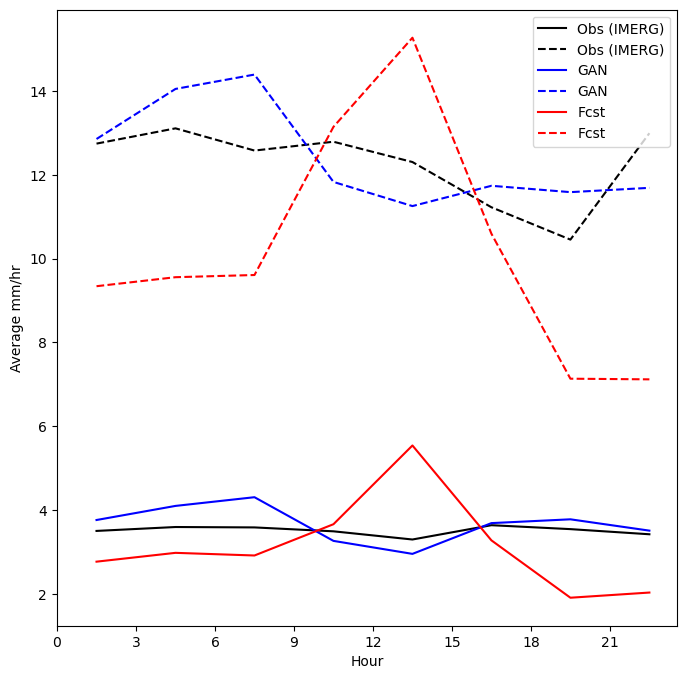

In [ ]:
# diurnal cycle of higher rainfall events

from dsrnngan.evaluation.scoring import get_metric_by_hour


diurnal_data_dict = {'Obs (IMERG)': truth_array[wet_hour_index, ...],
                    'GAN': cgan_corrected[wet_hour_index,:,:,0],
                    'Fcst': fcst_corrected[wet_hour_index, :,:]
                    }
diurnal_hours = np.array(hours)[wet_hour_index]
quantiles = [ 0.99, 0.999]
quantile_linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
color_lookup = {'GAN': 'b', 'Obs (IMERG)': 'k', 'Fcst': 'r'}


fig, ax = plt.subplots(1,1, figsize=(8,8))
for name, arr in tqdm(diurnal_data_dict.items()):
    
    for n, q in enumerate(quantiles):
        metric_fn_quantile = lambda x,y: np.quantile(x, q)
        quantile_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn_quantile, obs_array=arr, fcst_array=arr, hours=diurnal_hours, bin_width=3)

        mean_vals = np.array(list(quantile_by_hour.values()))
        ax.plot(np.array(list(quantile_by_hour.keys())), mean_vals, label=name, linestyle=quantile_linestyles[n], color=color_lookup[name])


ax.set_xticks(np.array(list(quantile_by_hour.keys())) - .5)
ax.set_xticklabels(hour_bin_edges)
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')
# ax.set_ylim(6,10)
ax.legend(loc='upper right')

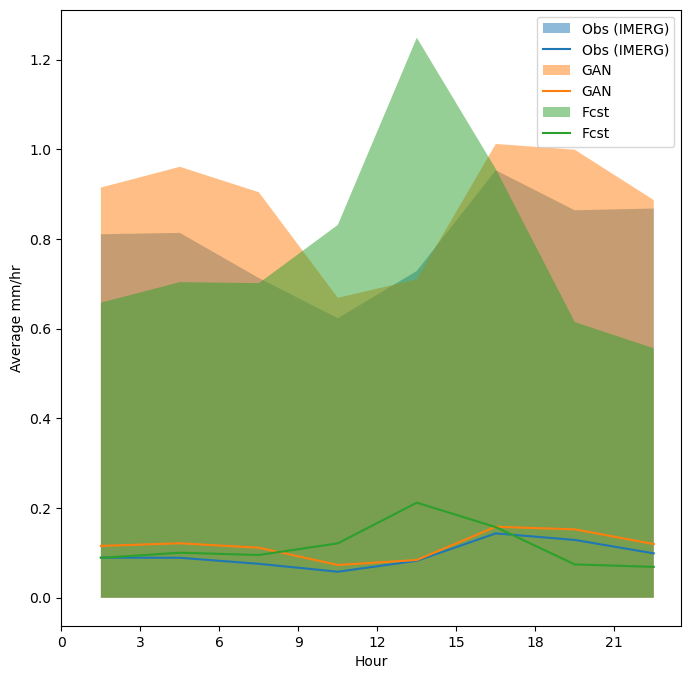

In [ ]:
from dsrnngan.evaluation.scoring import get_metric_by_hour

smoothed_diurnal_data_dict = {'Obs (IMERG)': truth_array,
                    'GAN': cgan_corrected[:n_samples,:,:,0],
                    'Fcst': fcst_corrected[:n_samples, :,:]
                    }
metric_fn_mean = lambda x,y: x.mean()
metric_fn_std = lambda x,y: x.std()

fig, ax = plt.subplots(1,1, figsize=(8,8))
for name, arr in smoothed_diurnal_data_dict.items():
    
    mean_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn_mean, obs_array=arr, fcst_array=arr, hours=hours, bin_width=3)
    std_by_hour, hour_bin_edges = get_metric_by_hour(metric_fn_std, obs_array=arr, fcst_array=arr, hours=hours, bin_width=3)

    mean_vals = np.array(list(mean_by_hour.values()))
    upper_vals = np.array(list(mean_by_hour.values())) + np.array(list(std_by_hour.values()))
    lower_vals = np.maximum(np.array(list(mean_by_hour.values())) - np.array(list(std_by_hour.values())), 0)

    ax.fill_between(np.array(list(mean_by_hour.keys())), y1=upper_vals, y2=lower_vals, label=name, alpha=0.5)
    ax.plot(np.array(list(mean_by_hour.keys())), mean_vals, label=name)


ax.set_xticks(np.array(list(mean_by_hour.keys())) - .5)
ax.set_xticklabels(hour_bin_edges)
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')
ax.legend()

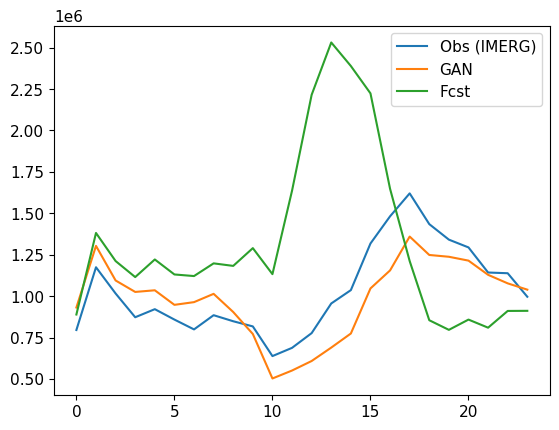

In [ ]:
from zoneinfo import ZoneInfo
from datetime import datetime, timezone

# Dates are in UTC, converting to EAT which is UTC + 3
time_array = [datetime(d.year, d.month, d.day, (hours[n]+3)%24) for n,d in enumerate(dates)]


smoothed_diurnal_data_dict = {'Obs (IMERG)': truth_array,
                    'GAN': cgan_corrected[:n_samples,:,:,0],
                    'Fcst': fcst_corrected[:n_samples, :,:]
                    }

fig, ax = plt.subplots(1,1)
for name, arr in smoothed_diurnal_data_dict.items():
    da = xr.DataArray(
        data=arr,
        dims=["hour", "lat", "lon"],
        coords=dict(
            lon=(longitude_range),
            lat=(latitude_range),
            hour=hours,
        ),
        attrs=dict(
            description="Precipitation.",
            units="mm/hr",
        ),
    )
    summed_data = np.sum(np.sum(da.groupby('hour').sum().values, axis=-1), axis=-1)
    ax.plot(summed_data, label=name)
ax.legend()

<matplotlib.legend.Legend>

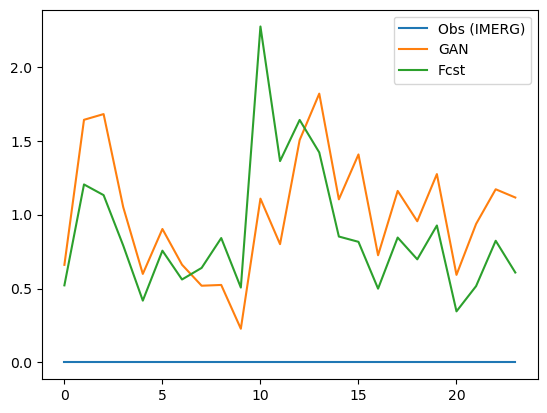

In [ ]:
fig, ax = plt.subplots(1,1)


for name, arr in smoothed_diurnal_data_dict.items():
    hours = [hour+3 for hour in hours]
    se_da = xr.DataArray(
        data=np.power(truth_array - arr[:n_samples, :,:], 2),
        dims=["hour", "lat", "lon"],
        coords=dict(
            lon=(longitude_range),
            lat=(latitude_range),
            hour=hours,
        ),
        attrs=dict(
            description="Precipitation.",
            units="mm/hr",
        ),
    )
    summed_data = np.sum(np.sum(se_da.groupby('hour').sum().values, axis=-1), axis=-1)
    ax.plot(summed_data / (truth_array.size / 24), label=name)
ax.legend()

# # mse by time
# se_da = xr.DataArray(
#         data=np.power(truth_array - fcst_corrected[:n_samples, :,:], 2),
#         dims=["hour", "lat", "lon"],
#         coords=dict(
#             lon=(longitude_range),
#             lat=(latitude_range),
#             hour=hours,
#         ),
#         attrs=dict(
#             description="Precipitation.",
#             units="mm/hr",
#         ),
#     )
# n_elements = truth_array.size
# summed_se = np.sum(np.mean(da.groupby('hour').sum().values, axis=-1), axis=-1)
# plt.plot(summed_se)

In [ ]:
import xarray as xr
from datetime import datetime
from dsrnngan.utils.utils import get_local_hour

diurnal_data_dict = {'Obs (IMERG)': truth_array,
                    'GAN': cgan_corrected[:n_samples,:,:,0],
                    'Fcst': fcst_corrected
                    }

time_array = [datetime(d.year, d.month, d.day, hours[n]) for n,d in enumerate(dates)]

truth_da = xr.DataArray(
    data=truth_array,
    dims=["hour", "lat", "lon"],
    coords=dict(
        lon=(longitude_range),
        lat=(latitude_range),
        hour=hours,
    ),
    attrs=dict(
        description="Precipitation.",
        units="mm/hr",
    ),
)


max_hour_arrays = {}
# for name, arr in diurnal_data_dict.items():
name = 'GAN'
arr = diurnal_data_dict[name]


da = xr.DataArray(
    data=arr,
    dims=["hour", "lat", "lon"],
    coords=dict(
        lon=(longitude_range),
        lat=(latitude_range),
        hour=hours,
    ),
    attrs=dict(
        description="Precipitation.",
        units="mm/hr",
    ),
)



In [ ]:

(_, width, height) = grouped_data.shape

hourly_sum = {(l, get_local_hour(h, longitude_range[l], np.mean(latitude_range))): grouped_data[h,:,l] for h in range(0,24) for l in range(len(longitude_range))}



In [ ]:

max_hour_arrays[name] = np.empty((len(latitude_range), len(longitude_range)))
for lt, lat in enumerate(latitude_range):
    for ln, lon in enumerate(longitude_range):

        hourly_dict = {hr: hourly_sum[(ln, hr)][lt] for hr in range(0,24)}
        max_hour_arrays[name][lt,ln] = {v:k for k,v in hourly_dict.items()}[max(hourly_dict.values())]
            
fig, ax = plt.subplots(2,1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize = (12,16))
n=0
for name, max_hour_array in max_hour_arrays.items():
    if name != 'Obs (IMERG)':
        
        im = plot_contourf(ax[n], max_hour_array - max_hour_arrays['Obs (IMERG)'], name, lat_range=latitude_range, lon_range=longitude_range, value_range=np.linspace(-24, 24, 10))
        n+=1


# Locations of high quantiles

In [ ]:
quantile_boundaries = [np.round(item, 6) for item in quantile_boundaries]

In [ ]:
truth_quantiles = np.quantile(truth_array, quantile_boundaries)
sample_quantiles = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries)
fcst_corrected_quantiles = np.quantile(fcst_corrected, quantile_boundaries)

In [ ]:
fig, axs = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))

threshold = 55
digitized_truth = np.digitize(truth_array, truth_quantiles)
digitized_sample = np.digitize(samples_gen_array[:,:,:,0], sample_quantiles)


im = plot_contourf(axs, np.sum(digitized_sample >= threshold, axis=0) / np.sum(digitized_truth >= threshold, axis=0), title=f'', cmap='Reds', lat_range=latitude_range, 
                   lon_range=longitude_range)
plt.colorbar(im, ax=axs)

# im = plot_contourf(axs[1], , title=f'', cmap='Reds', lat_range=latitude_range, 
#                    lon_range=longitude_range)
# plt.colorbar(im, ax=axs[1])

# Ratio of quantiles

In [ ]:
truth_quantiles = np.quantile(truth_array, quantile_boundaries, axis=0)
sample_quantiles = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries, axis=0)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries, axis=0)
fcst_corrected_quantiles = np.quantile(fcst_corrected, quantile_boundaries, axis=0)

In [ ]:
quantile = 0.9999

# quantile_index = quantile_boundaries.index(quantile)
quantile_index = 59

t = truth_quantiles[quantile_index, :,:]
s = sample_quantiles[quantile_index, :, :]

fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))

im = plot_contourf(ax, s / t, title=f'', cmap='Reds', lat_range=latitude_range, 
                   lon_range=longitude_range)
plt.colorbar(im, ax=ax)

## Check locations of max values

In [ ]:
max_samples_gen = np.max(np.max(samples_gen_array, axis=-1), axis=0)
max_truth = np.max(truth_array, axis=0)

In [ ]:
fig, ax = plt.subplots(2,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))
threshold = 300
im = plot_contourf(ax[0], (max_samples_gen > threshold), title=f'Sample max rainfall > {threshold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=DEFAULT_LONGITUDE_RANGE)
plt.colorbar(im, ax=ax[0])

obs_thresold = 80
im = plot_contourf(ax[1], (max_truth > obs_thresold), title=f'IMERG max rainfall > {obs_thresold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=longitude_range)
plt.colorbar(im, ax=ax[1])

## Single pixel time series


In [ ]:

log_folder_consecutive = '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201810-201812_e50'

with open(os.path.join(log_folder_consecutive, f'arrays-160000.pkl'), 'rb') as ifh:
    consecutive_arrays = pickle.load(ifh)
    
cons_truth_array = consecutive_arrays['truth']
cons_samples_gen_array = consecutive_arrays['samples_gen']
cons_fcst_array = consecutive_arrays['fcst_array']
cons_ensmean_array = np.mean(consecutive_arrays['samples_gen'], axis=-1)
cons_dates = consecutive_arrays['dates']
cons_hours = consecutive_arrays['hours']


## Check training data for high rainfall

In [ ]:
# Check range of values in training data
from dsrnngan.data.tfrecords_generator import create_mixed_dataset, DataGenerator

train = DataGenerator('train',
                           batch_size=1,
                           fcst_shape=(200, 200, 20),
                            con_shape=(200, 200, 2),
                            out_shape=(200, 200, 1),
                           downsample=False, 
                           weights=[0.4, 0.3, 0.2, 0.1], 
                           records_folder='/user/work/uz22147/tfrecords/d34d309eb0e00b04', 
                           )



In [ ]:
from tqdm import tqdm
from dsrnngan.data.data import denormalise

max_rainfall = 0
take_n = 20000

for a in tqdm(train.take(take_n).as_numpy_iterator()):
    ifs_input = a[0]['lo_res_inputs']
    imerg_output = a[1]['output']
    
    if denormalise(imerg_output.max()) > max_rainfall:
        max_rainfall = denormalise(imerg_output.max())

## Quantiles with training time

In [ ]:
from sklearn.linear_model import LinearRegression

model_numbers = sorted([153600,147200,140800,134400,128000,121600,115200,108800])

truth_quantiles = {}
sample_quantiles = {}

for model_number in tqdm(model_numbers, total=len(model_numbers)):
    if model_number == 160000:
        log_folder = '/user/work/uz22147/logs/cgan/38fba564f1c9852b/n1000_201806-201905_e50'
    else:
        log_folder = '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201806-201905_e50'

    with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
        arrays = pickle.load(ifh)
        
    truth_array = arrays['truth']
    samples_gen_array = arrays['samples_gen']
    fcst_array = arrays['fcst_array']
    ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
    training_dates = arrays['dates']
    training_hours = arrays['hours']

    (n_samples, width, height, ensemble_size) = samples_gen_array.shape

    ## This is needed until code is fixed

    if model_number == 160000:
        for n in range(fcst_array.shape[0]):
            fcst_array[n,:,:] = denormalise(fcst_array[n,:,:])
            
    number_in_top_range = 10000
    quantile_boundaries = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] + list(np.linspace(0.9, 1.0, number_in_top_range))
    truth_quantiles[model_number] = np.quantile(truth_array, quantile_boundaries)
    sample_quantiles[model_number] = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
    print('Number data points per quantile in top range: ', 0.1*len(truth_array.flatten()) / number_in_top_range)
    print('percentile steps in top range: ', 10 / number_in_top_range)
    
fig, ax = plt.subplots(1,1, figsize=(8,6))

for n, model_number in enumerate(model_numbers):
    
    truth_q = truth_quantiles[model_number]
    sample_q = sample_quantiles[model_number]
    
    ax.plot(truth_q, sample_q, label=model_number)

ax.legend()
plt.savefig('cgan_metrics/quantiles_by_iterations.png')

In [ ]:
!zip -r cgan_metrics.zip cgan_metrics